<a href="https://colab.research.google.com/github/EgleBut/files_for_projects/blob/main/EmpaticaE4Sress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Read data ##

Data is to be stored in the following format:
```
data =
[
    { // data of subject 01
        "bvp":
        {
            "raw":[] // array of floating point numbers representing bvp (ppg) sampled at 64 Hz
            "labels":[0,..,0,1,..,1,0,..,0,2,..,2,0,..,0,3,..,3,0,..,0,4,..,4,0,..,0,5,..,5,0,..,0] // labels code the activity which was carred at each raw data sample
            \* Labels correspond to the following activities of the protocol described at                                    *\
            \* https://github.com/blaztoma/roadmaster/blob/main/data_from_open_reps/empatica_E4_stress/PPG_EDA_data_set.pdf: *\                                                                
            \*  0 - Rest   *\
            \*  1 - Task 1 *\
            \*  2 - Task 2 *\
            \*  3 - Task 3 *\
            \*  4 - Task 4 *\
            \*  5 - Task 5 *\
        },
        "eda":
        {
            "raw":[] // array of floating point numbers representing eda sampled at 4 Hz
            "labels":[0,..,0,1,..,1,0,..,0,2,..,2,0,..,0,3,..,3,0,..,0,4,..,4,0,..,0,5,..,5,0,..,0]
        },
        "temp":
        {
            "raw":[] // array of floating point numbers representing temperature sampled at 4 Hz
            "labels":[0,..,0,1,..,1,0,..,0,2,..,2,0,..,0,3,..,3,0,..,0,4,..,4,0,..,0,5,..,5,0,..,0]
        }
    },
    ...,
    { // data of subject 29
        "bvp":...
        "eda":...
        "temp":...
    }
]
```

In [8]:
! wget https://github.com/blaztoma/roadmaster/raw/main/data_from_open_reps/empatica_E4_stress/EmpaticaE4Stress.zip

--2024-04-15 13:36:49--  https://github.com/blaztoma/roadmaster/raw/main/data_from_open_reps/empatica_E4_stress/EmpaticaE4Stress.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-04-15 13:36:49 ERROR 404: Not Found.



Issues:
- Starting form subject 3 eda data can not be read due to incorrect data format.

In [ ]:
import os

PATH = "..\\data_from_open_reps\\empatica_E4_stress\\subjects"

dataSubjects = [subdirectory[0] for subdirectory in os.walk(PATH)]

data = []
for i , subject in enumerate(dataSubjects[1:]):
    print("{}. {}".format(i + 1, subject))
    with open(os.path.join(subject, "BVP.csv")) as file:
        data.append(
            {
                "bvp":
                {
                    "raw": [float(value) for value in file.readlines()]
                }
            }
        )

    # with open(os.path.join(subject, "EDA.csv")) as file:
    #     data[i]["eda"] = { "raw": [float(value) for value in file.readlines()] }

    with open(os.path.join(subject, "TEMP.csv")) as file:
        data[i]["temp"] = { "raw": [float(value) for value in file.readlines()] }

    # with open(os.path.join(subject, "ACC.csv")) as file:
    #     data[i]["acc"] = { "raw": [float(value) for value in file.readlines()] }

1. ..\data_from_open_reps\empatica_E4_stress\subjects\subject_01
2. ..\data_from_open_reps\empatica_E4_stress\subjects\subject_02
3. ..\data_from_open_reps\empatica_E4_stress\subjects\subject_03
4. ..\data_from_open_reps\empatica_E4_stress\subjects\subject_04
5. ..\data_from_open_reps\empatica_E4_stress\subjects\subject_05
6. ..\data_from_open_reps\empatica_E4_stress\subjects\subject_06
7. ..\data_from_open_reps\empatica_E4_stress\subjects\subject_07
8. ..\data_from_open_reps\empatica_E4_stress\subjects\subject_08
9. ..\data_from_open_reps\empatica_E4_stress\subjects\subject_09
10. ..\data_from_open_reps\empatica_E4_stress\subjects\subject_10
11. ..\data_from_open_reps\empatica_E4_stress\subjects\subject_11
12. ..\data_from_open_reps\empatica_E4_stress\subjects\subject_12
13. ..\data_from_open_reps\empatica_E4_stress\subjects\subject_13
14. ..\data_from_open_reps\empatica_E4_stress\subjects\subject_14
15. ..\data_from_open_reps\empatica_E4_stress\subjects\subject_15
16. ..\data_from_op

## Filter BVP (PPG) data ##

As paper suggests we filter the bvp data with Chebyshev II order-4 filter with a stopband attenuation of 20 dB and a passband of 0.5–5 Hz.

In [ ]:
from scipy import signal

sos = signal.cheby2(4, 20, [0.5 / (64 / 2) , 5 / (64 / 2)], btype = "bandpass", output = "sos")

for i in range(len(data)):
    data[i]["bvp"]["filtered"] = signal.sosfilt(sos, data[i]["bvp"]["raw"])



## Add labels ##

### Define function for labels calculation ###

In [ ]:
def calculateLabels(dataSize, fs):
    minute = 60*fs
    labels = [0] * dataSize
    labels[minute*3:minute*13] = [1] * len(labels[minute*3:minute*13])
    labels[minute*15:minute*20] = [2] * len(labels[minute*15:minute*20])
    labels[minute*22:minute*25] = [3] * len(labels[minute*22:minute*25])
    labels[minute*27:(round(len(labels)/fs/60)-5)*minute] = [4] * len(labels[minute*27:(round(len(labels)/fs/60)-5)*minute])
    labels[minute*(round(len(labels)/fs/60)-3):minute*(round(len(labels)/fs/60)-2)] = [5] * len(labels[minute*(round(len(labels)/fs/60)-3):minute*(round(len(labels)/fs/60)-2)])

    return labels

### Add labels to raw data ###

In [ ]:
for i in range(len(data)):
    data[i]["bvp"]["labels"] = calculateLabels(len(data[i]["bvp"]["raw"]), 64)
    # data[i]["eda"]["labels"] = calculateLabels(len(data[i]["eda"]["raw"]), 4)
    data[i]["temp"]["labels"] = calculateLabels(len(data[i]["temp"]["raw"]), 4)

### Sanity check ###

In [ ]:
for i, item in enumerate(data):
    print(
        "{}. raw bvp data size:{}, label size {} -> {}".format(
            i + 1,
            len(item["bvp"]["raw"]),
            len(item["bvp"]["labels"]),
            str(len(item["bvp"]["raw"]) == len(item["bvp"]["labels"]))
            )
        )
    # print(
    #     "Raw eda data size:{}, label size {} -> {}".format(
    #         len(item["eda"]["raw"]),
    #         len(item["eda"]["labels"]),
    #         str(len(item["eda"]["raw"]) == len(item["eda"]["labels"]))
    #         )
    #     )
    print(
        "Raw temperature data size:{}, label size {} -> {}".format(
            len(item["temp"]["raw"]),
            len(item["temp"]["labels"]),
            str(len(item["temp"]["raw"]) == len(item["temp"]["labels"]))
            )
        )

1. raw bvp data size:160369, label size 160369 -> True
Raw temperature data size:10016, label size 10016 -> True
2. raw bvp data size:150777, label size 150777 -> True
Raw temperature data size:9426, label size 9426 -> True
3. raw bvp data size:132880, label size 132880 -> True
Raw temperature data size:8306, label size 8306 -> True
4. raw bvp data size:134959, label size 134959 -> True
Raw temperature data size:8434, label size 8434 -> True
5. raw bvp data size:133364, label size 133364 -> True
Raw temperature data size:8338, label size 8338 -> True
6. raw bvp data size:138479, label size 138479 -> True
Raw temperature data size:8658, label size 8658 -> True
7. raw bvp data size:137192, label size 137192 -> True
Raw temperature data size:8578, label size 8578 -> True
8. raw bvp data size:142153, label size 142153 -> True
Raw temperature data size:8882, label size 8882 -> True
9. raw bvp data size:142153, label size 142153 -> True
Raw temperature data size:8882, label size 8882 -> True

## Visualise data ##

Note: matplotlib must be install, if not, first run `pip install matplotlib` on a terminal.

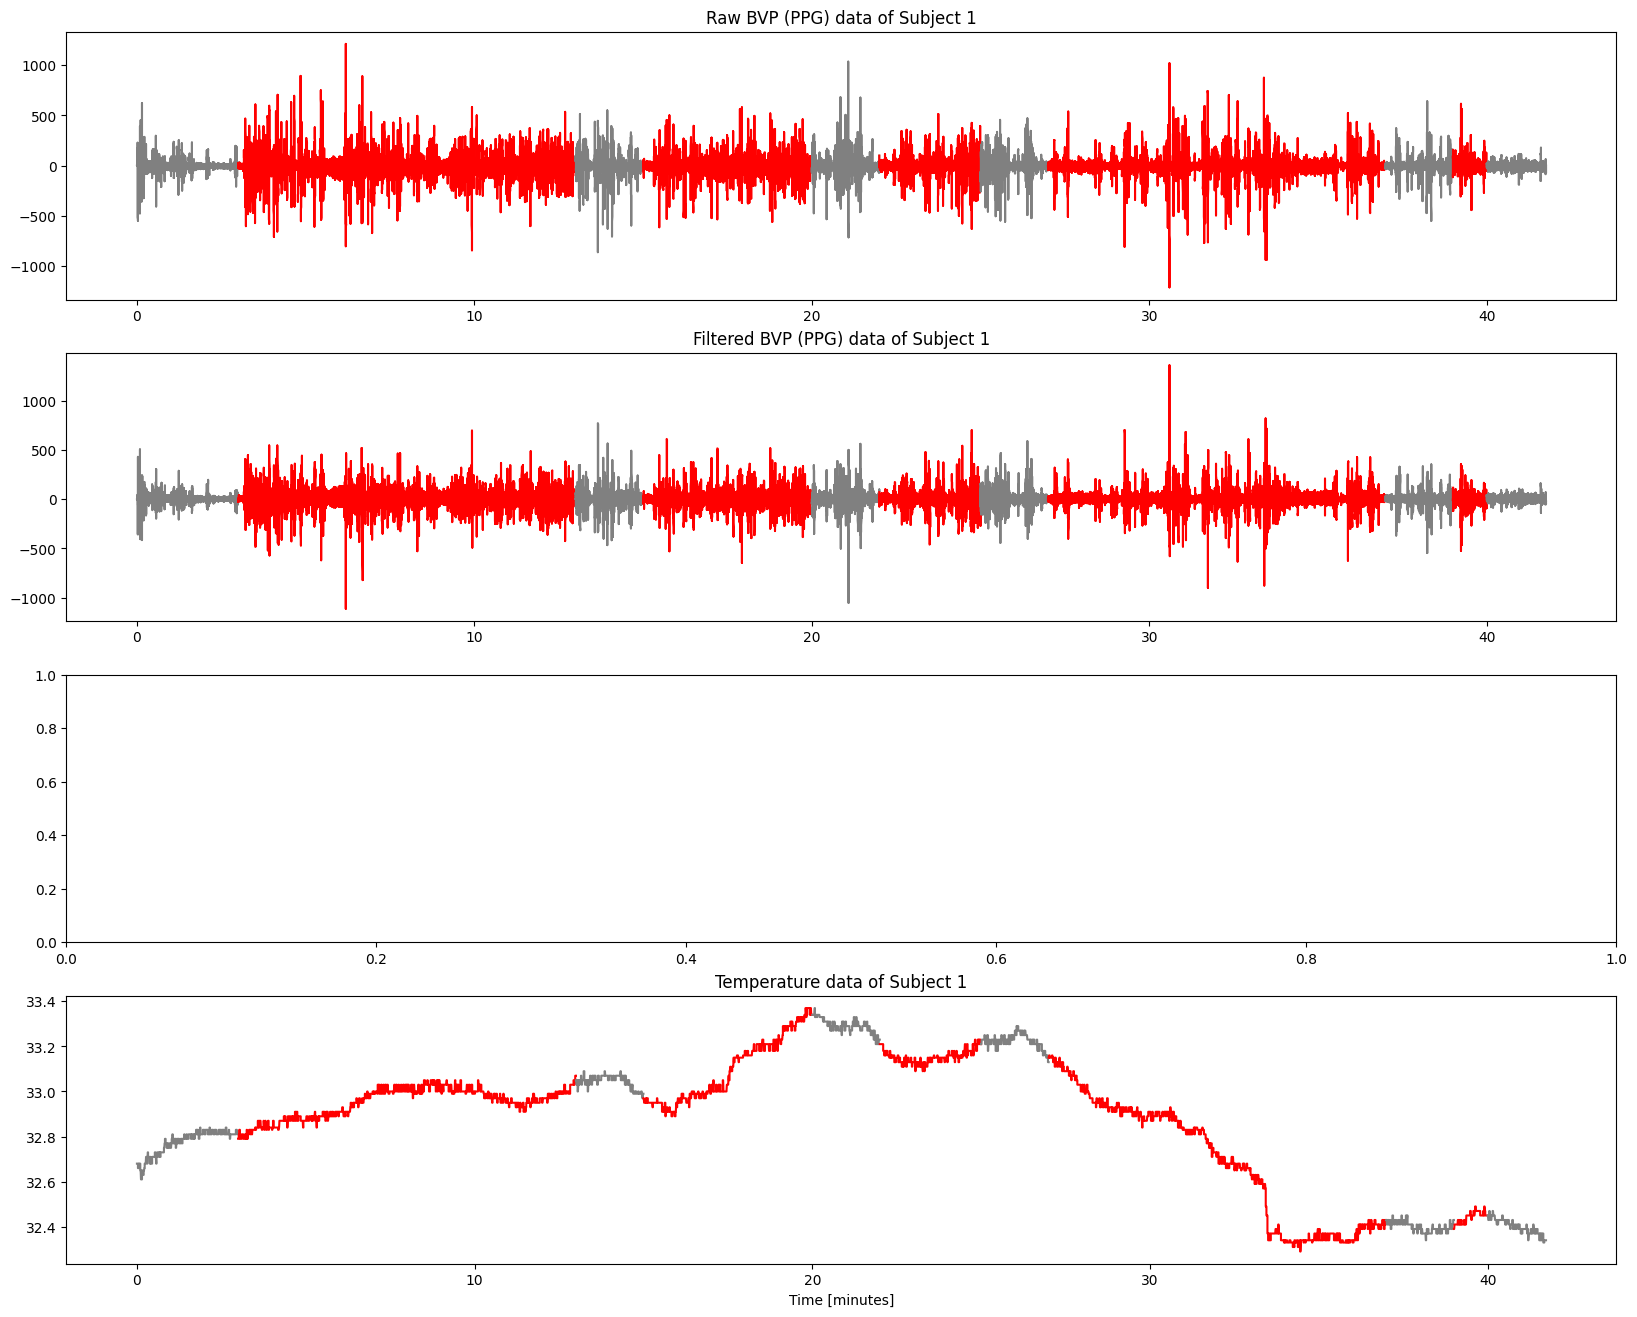

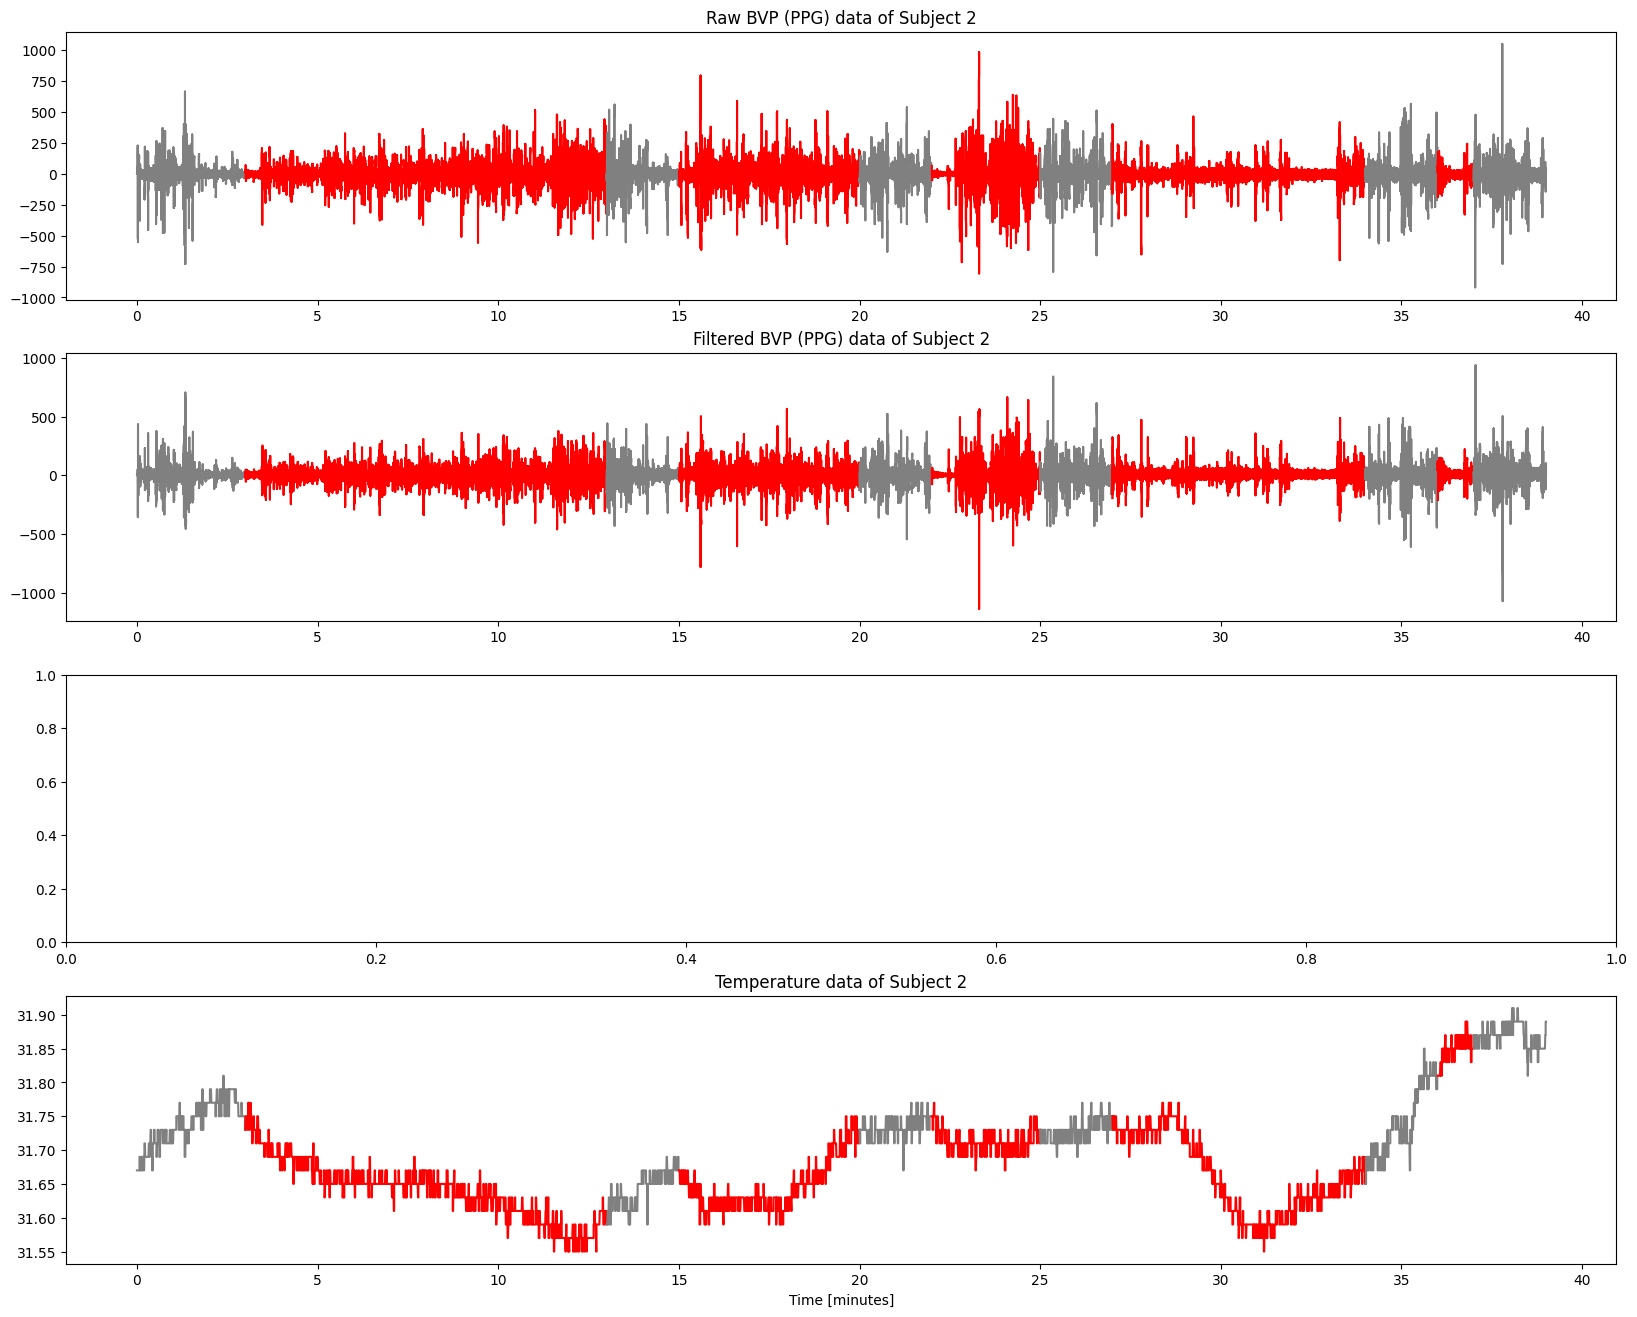

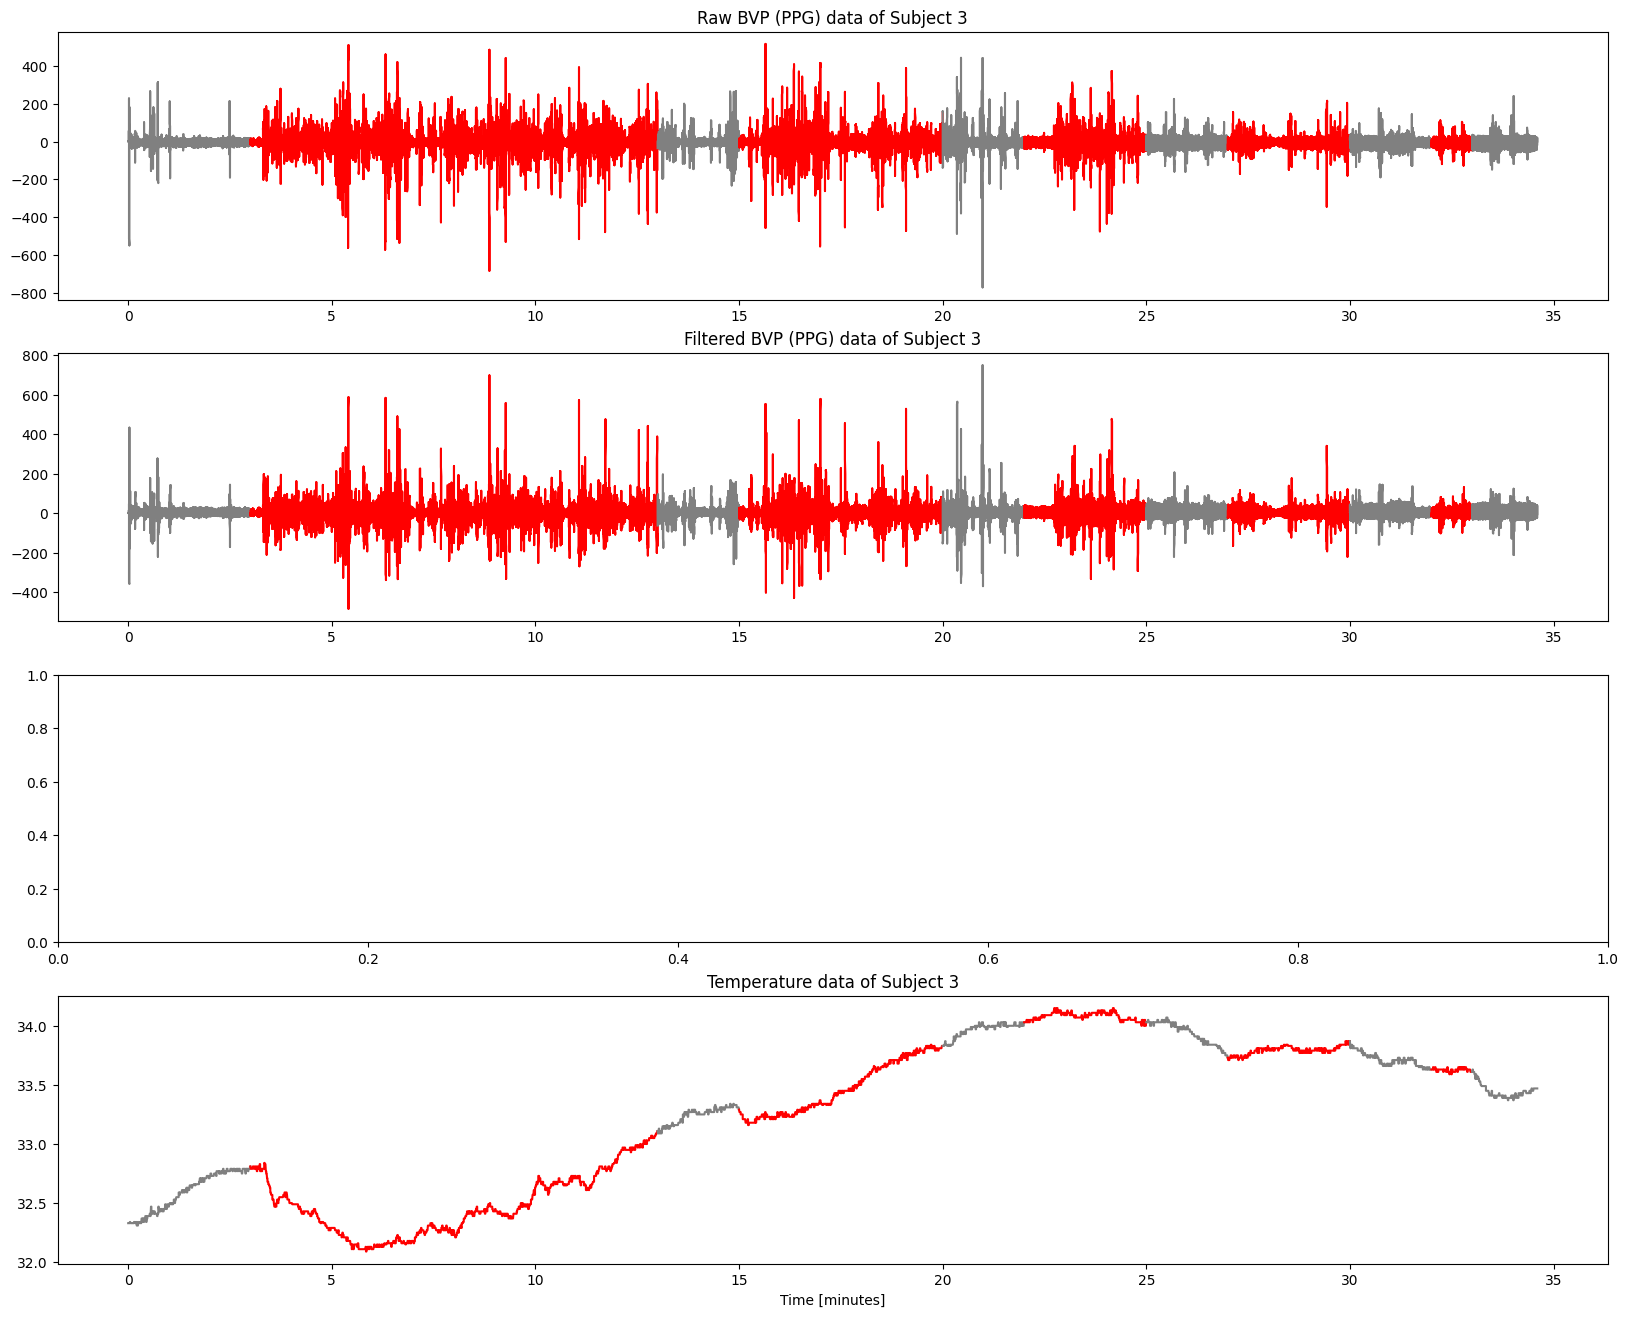

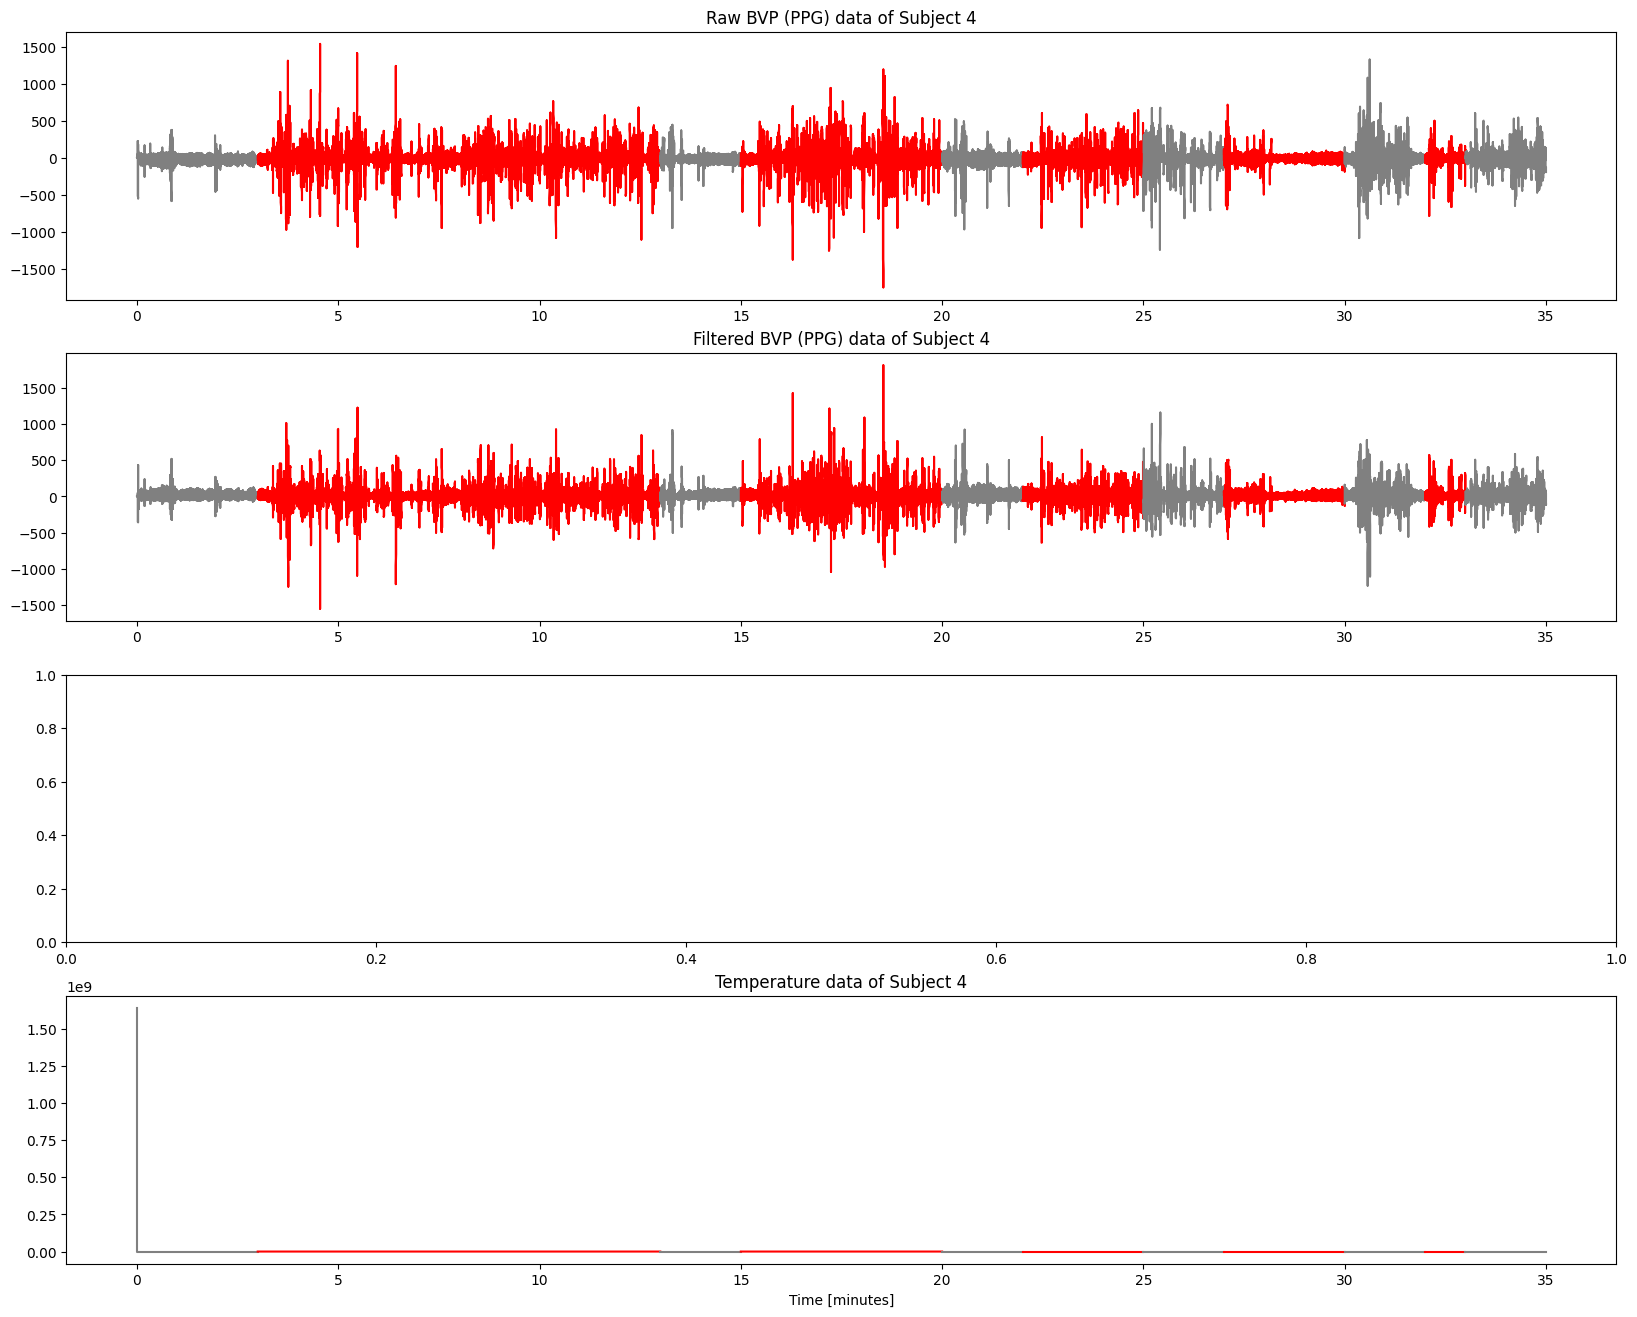

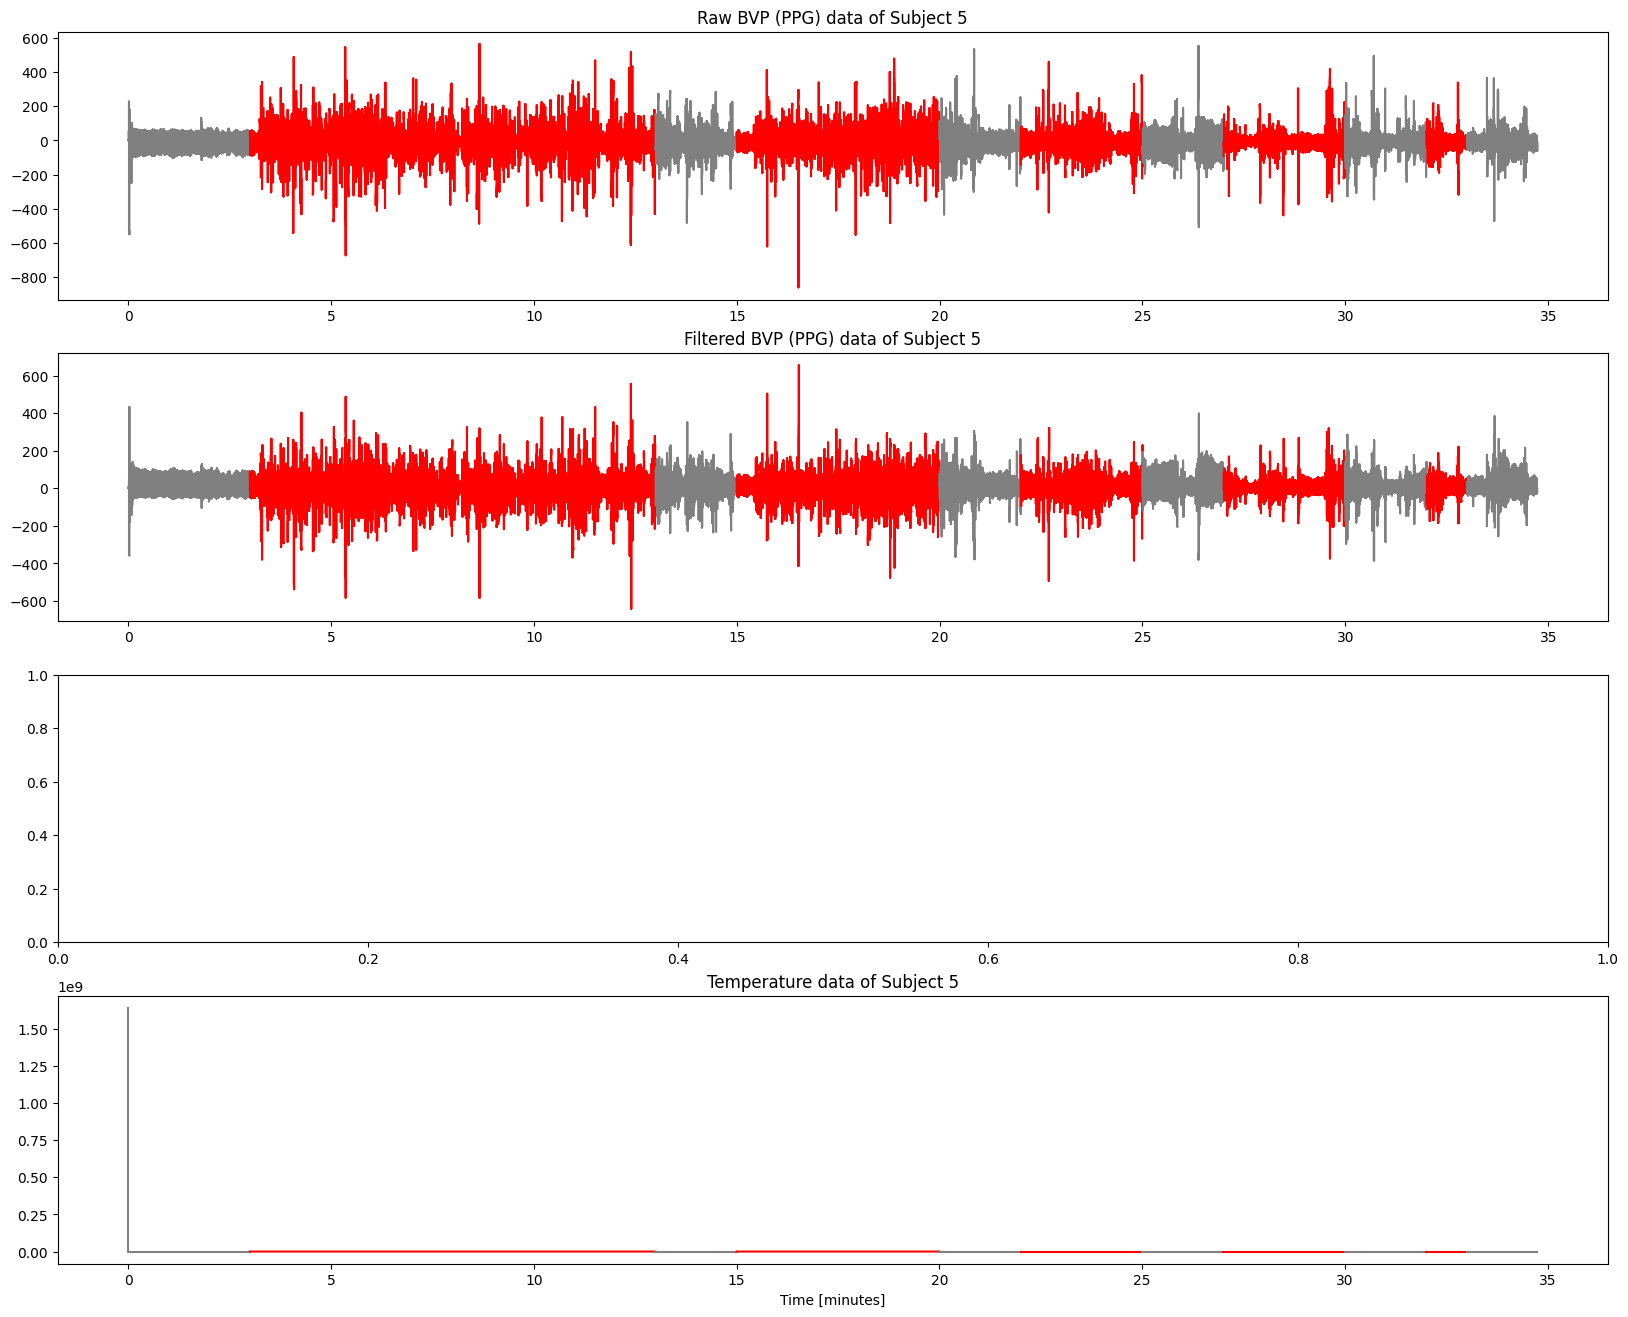

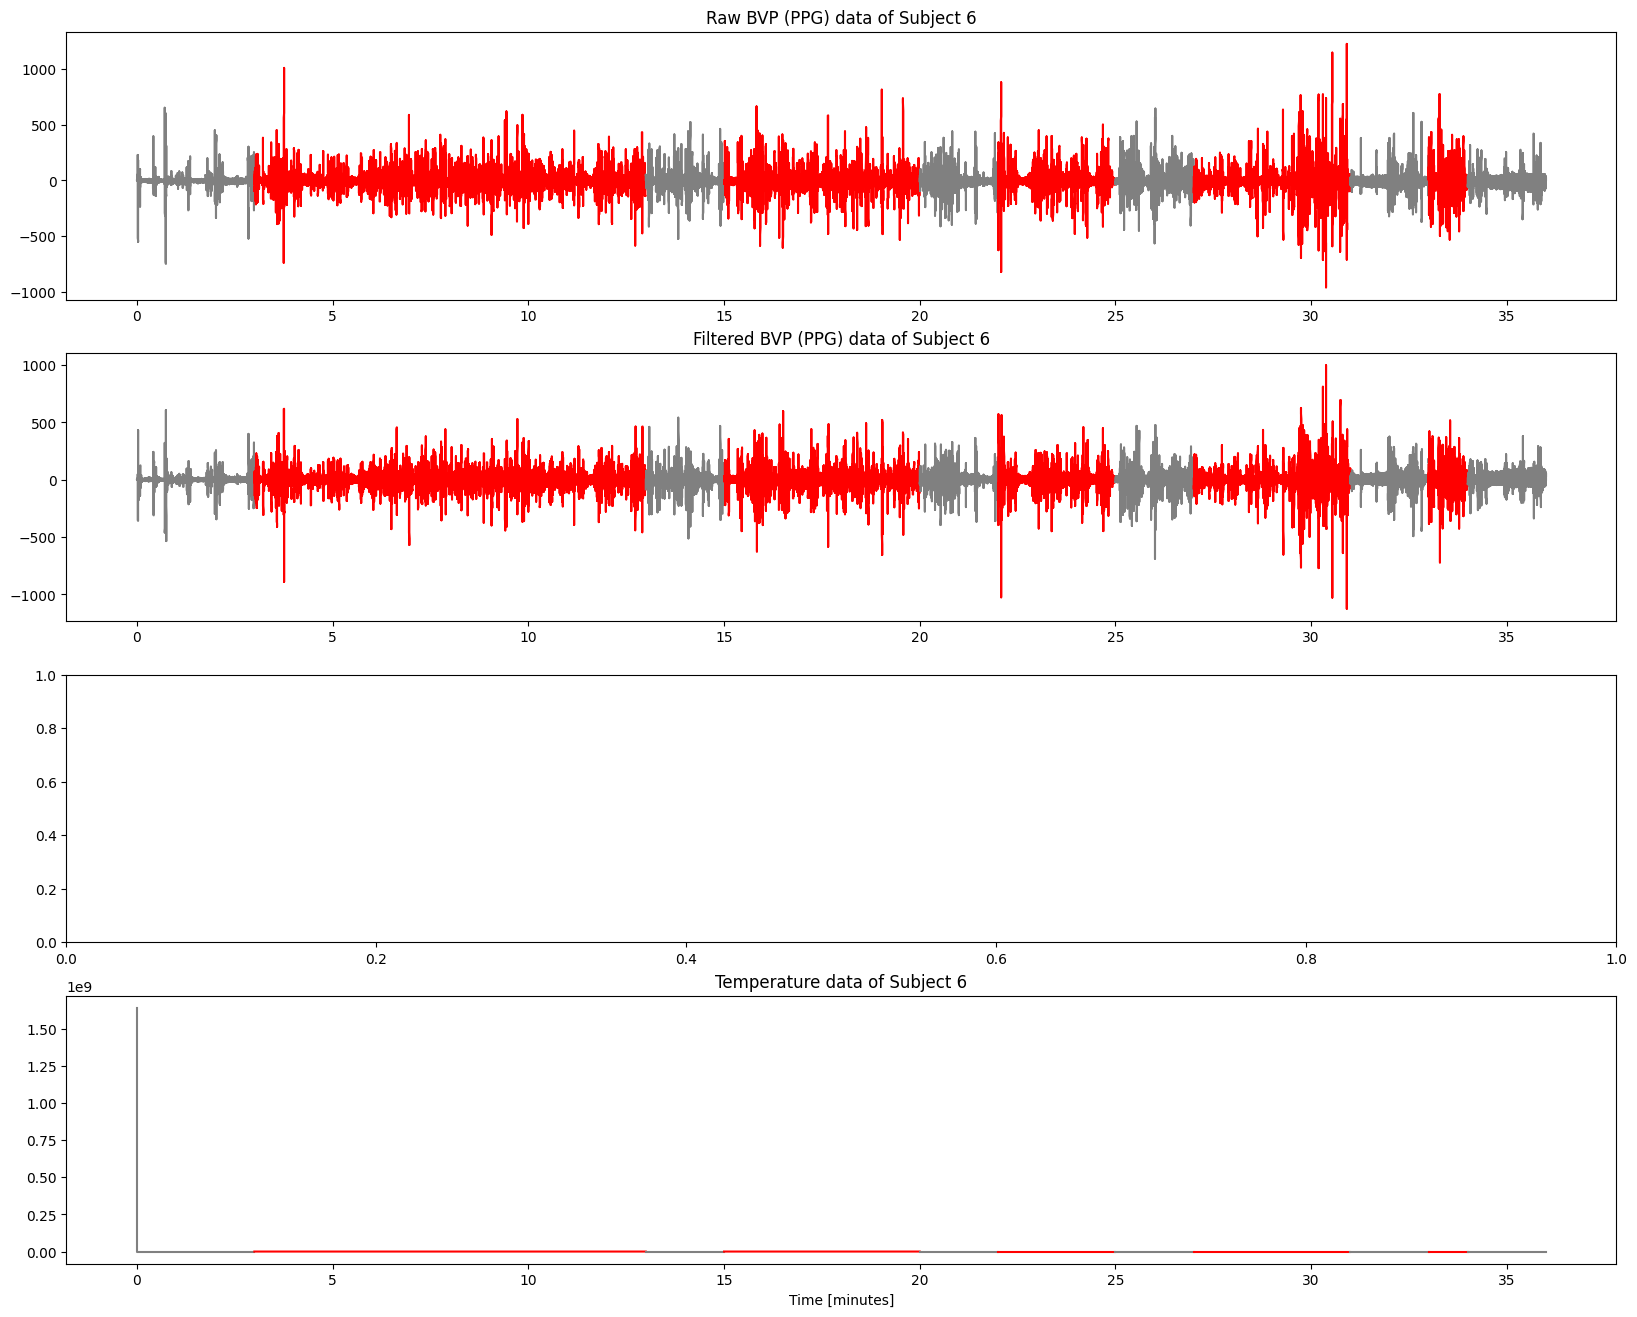

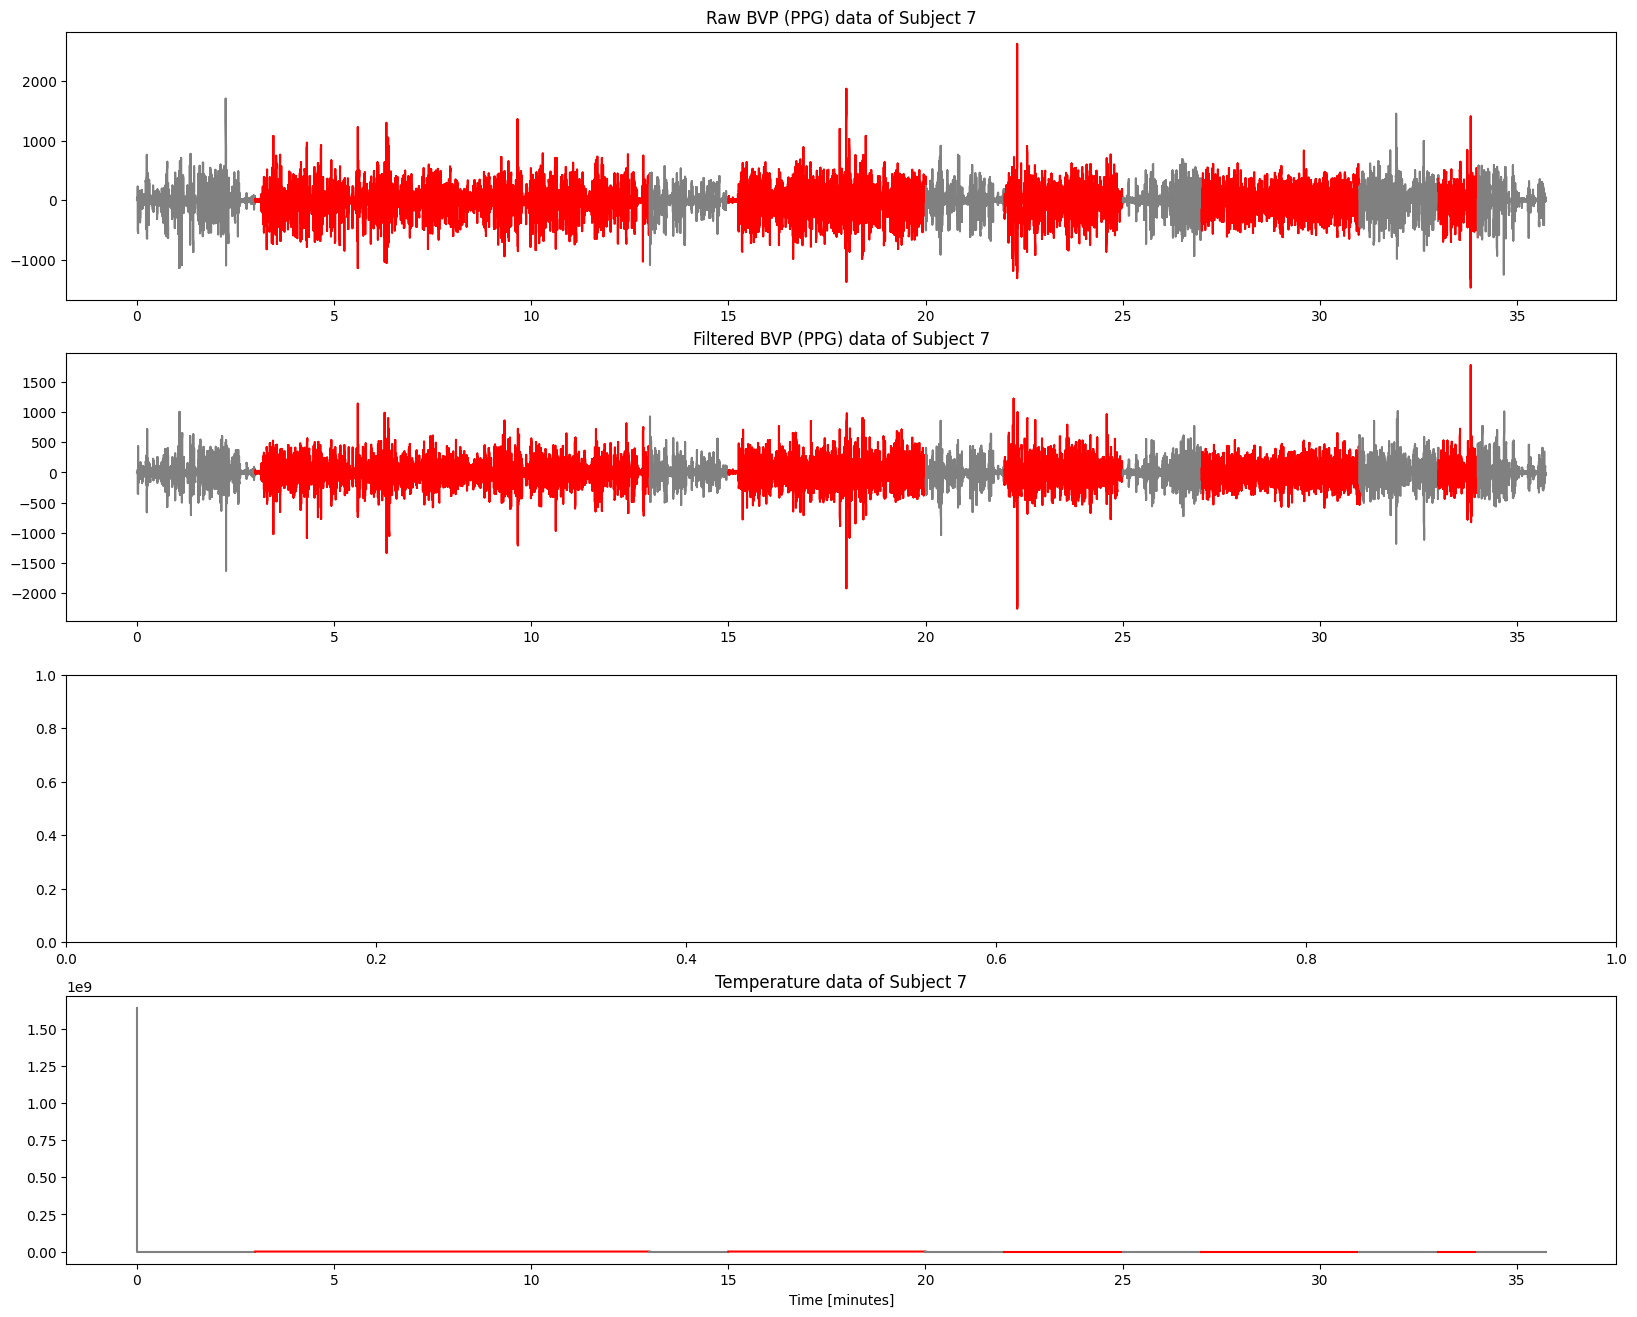

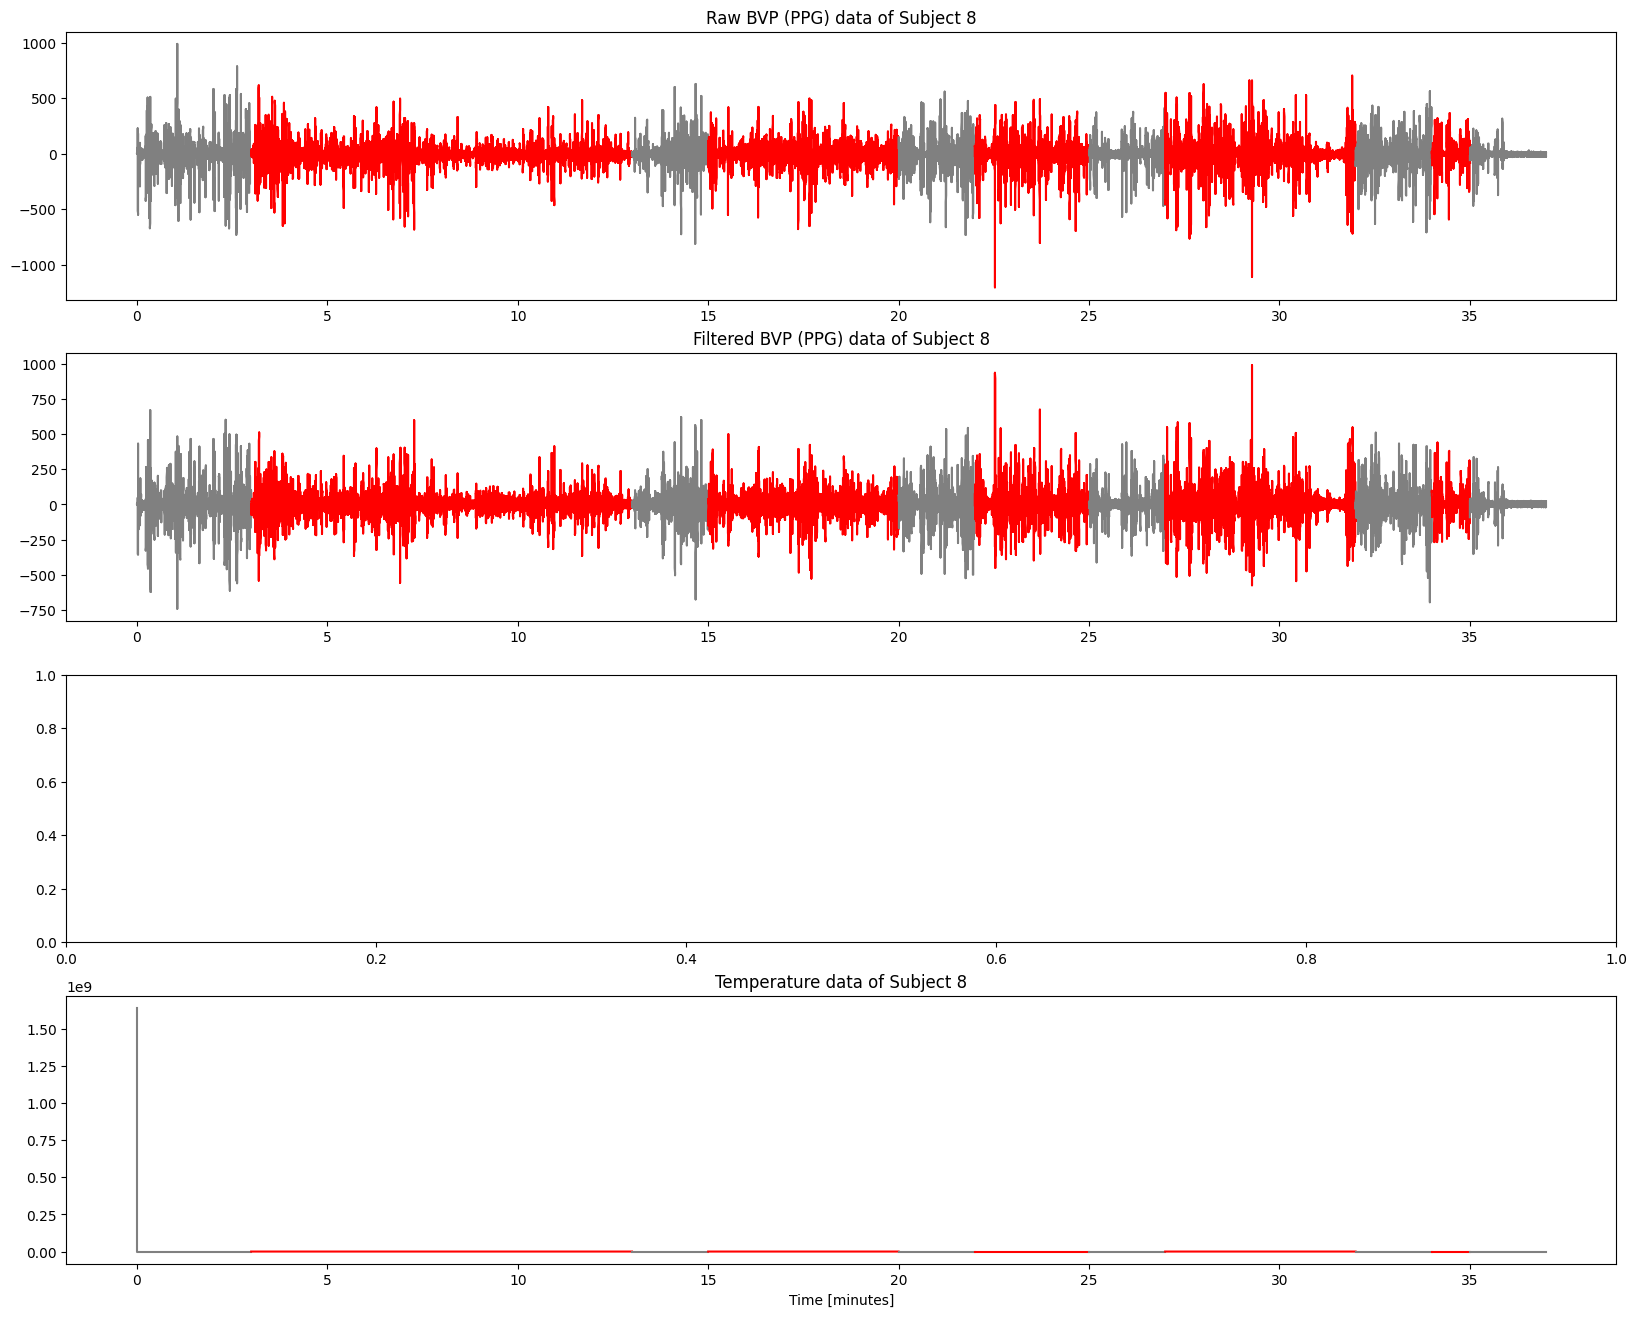

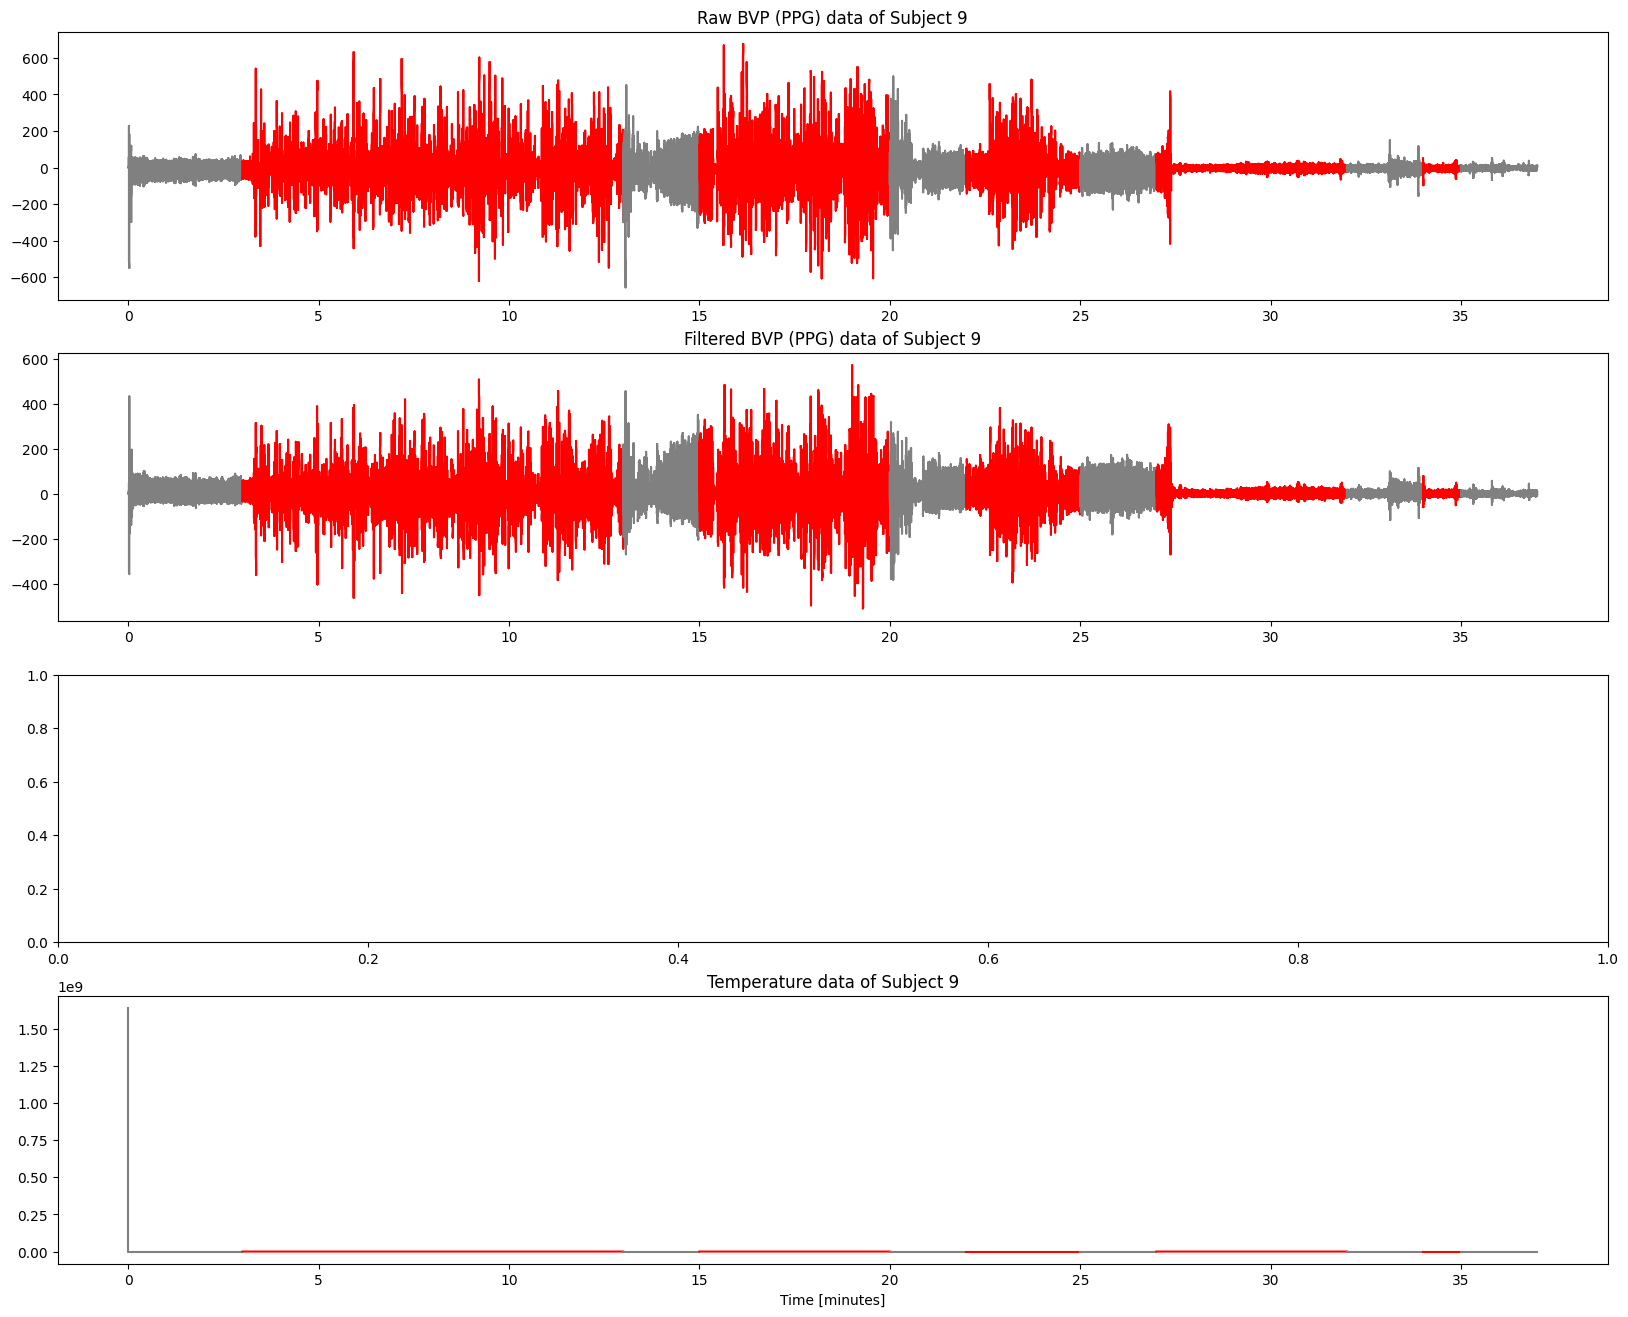

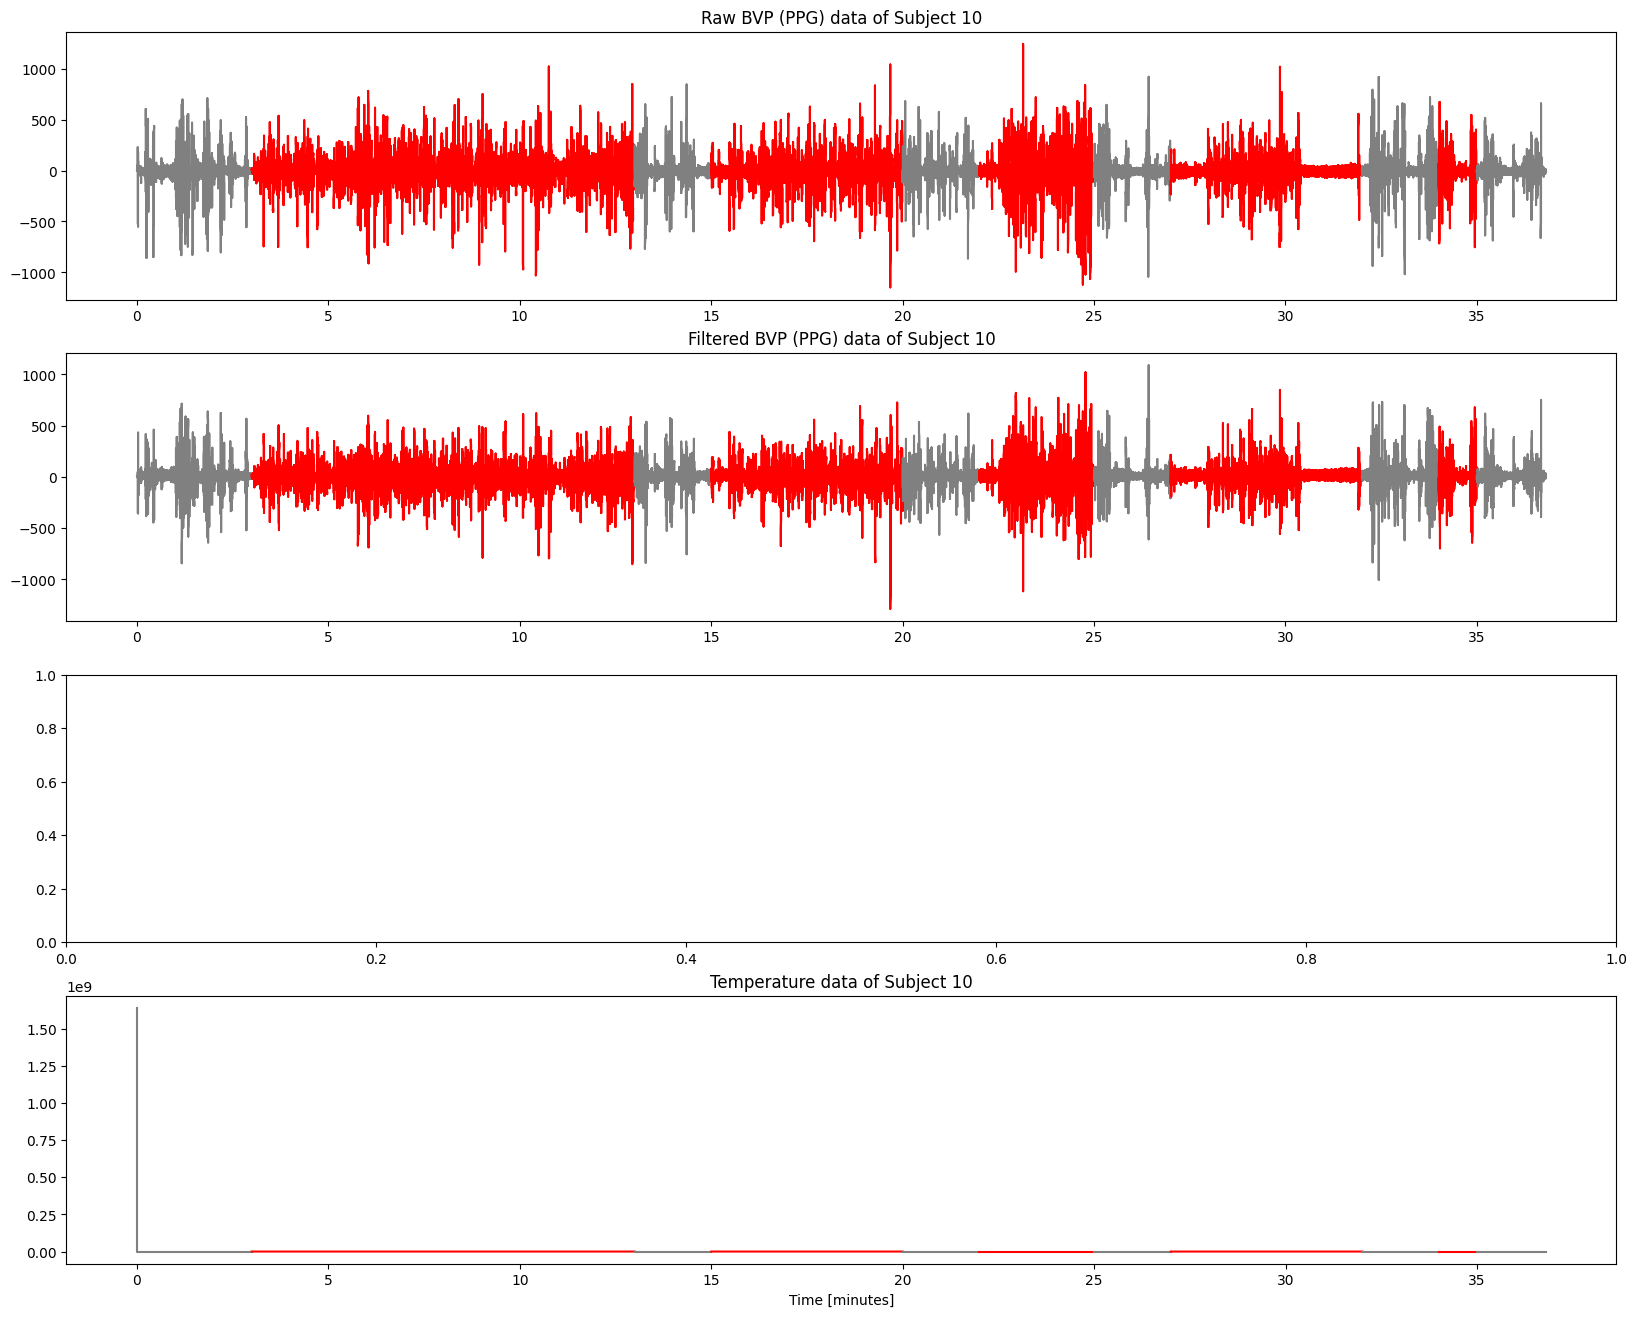

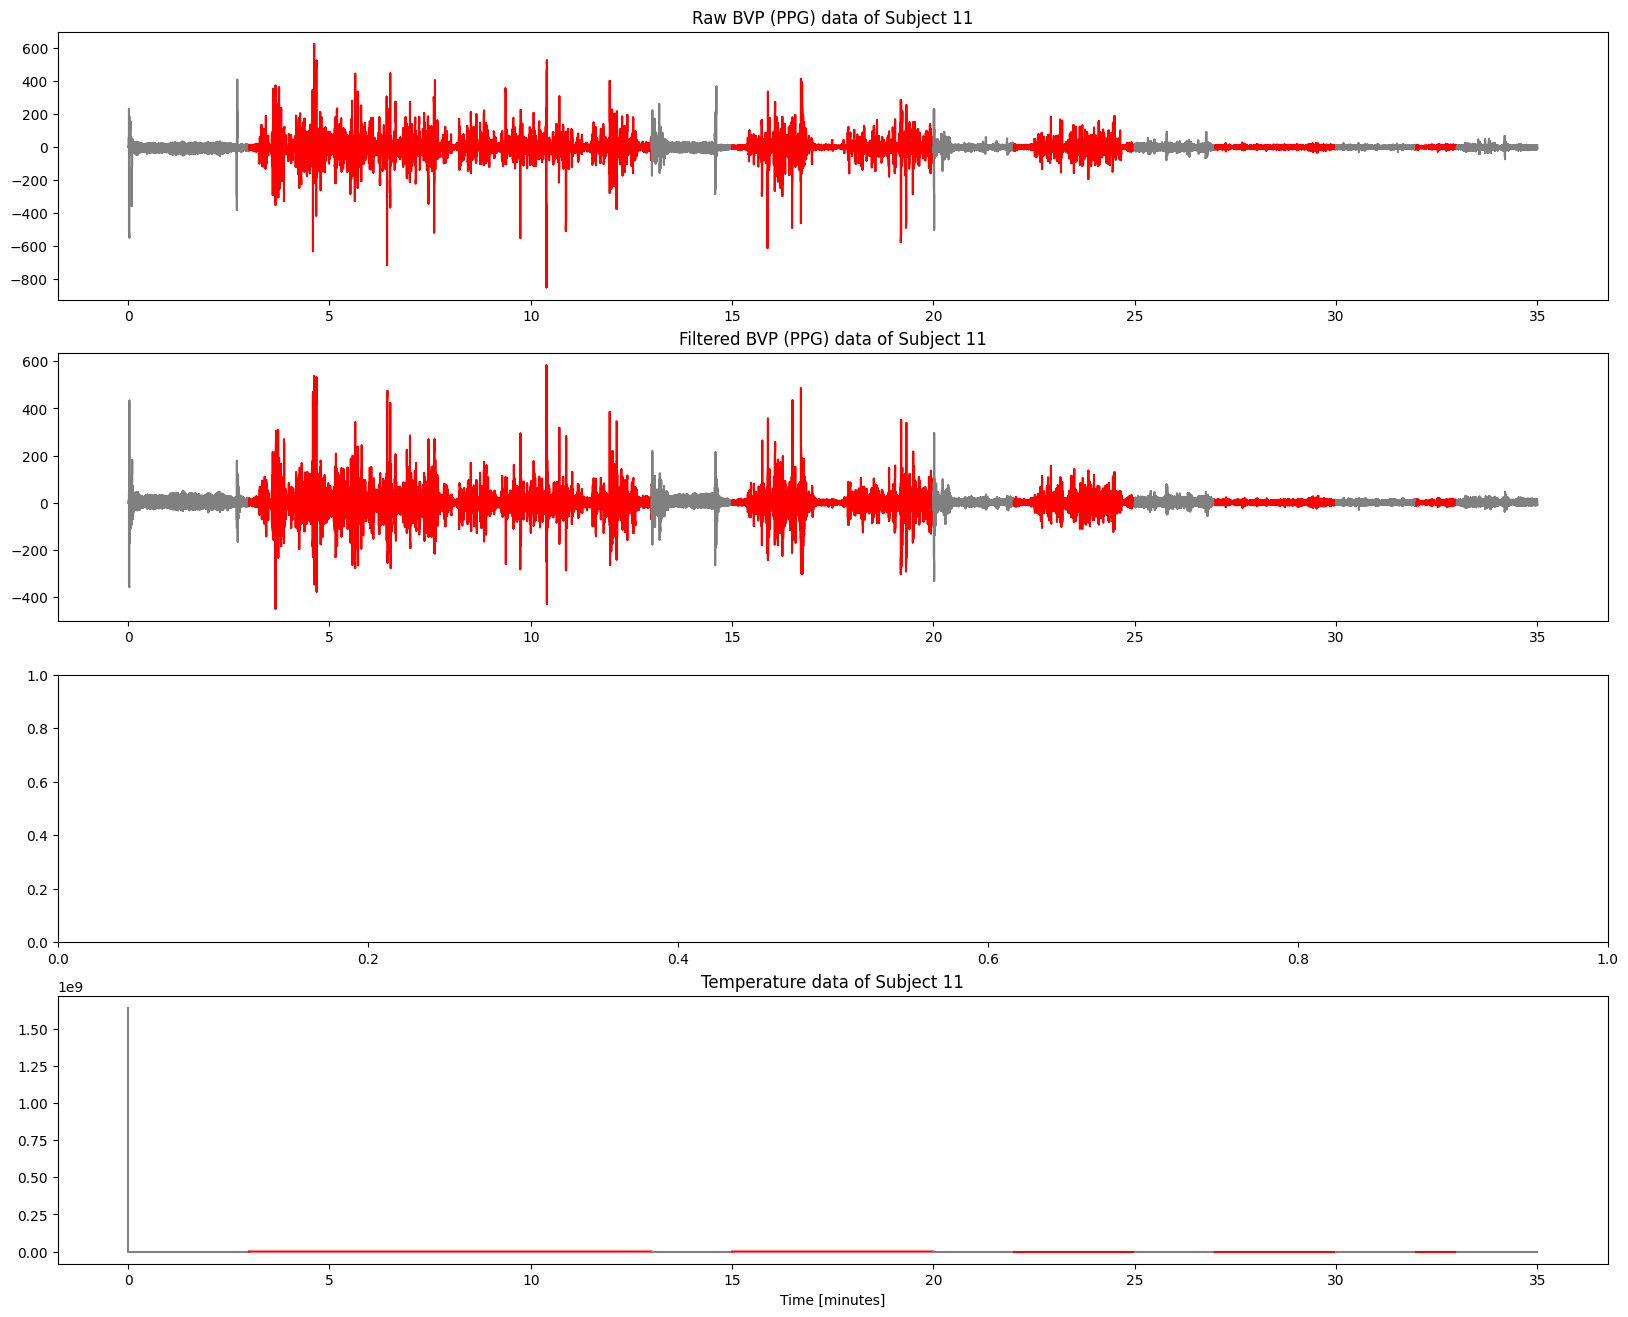

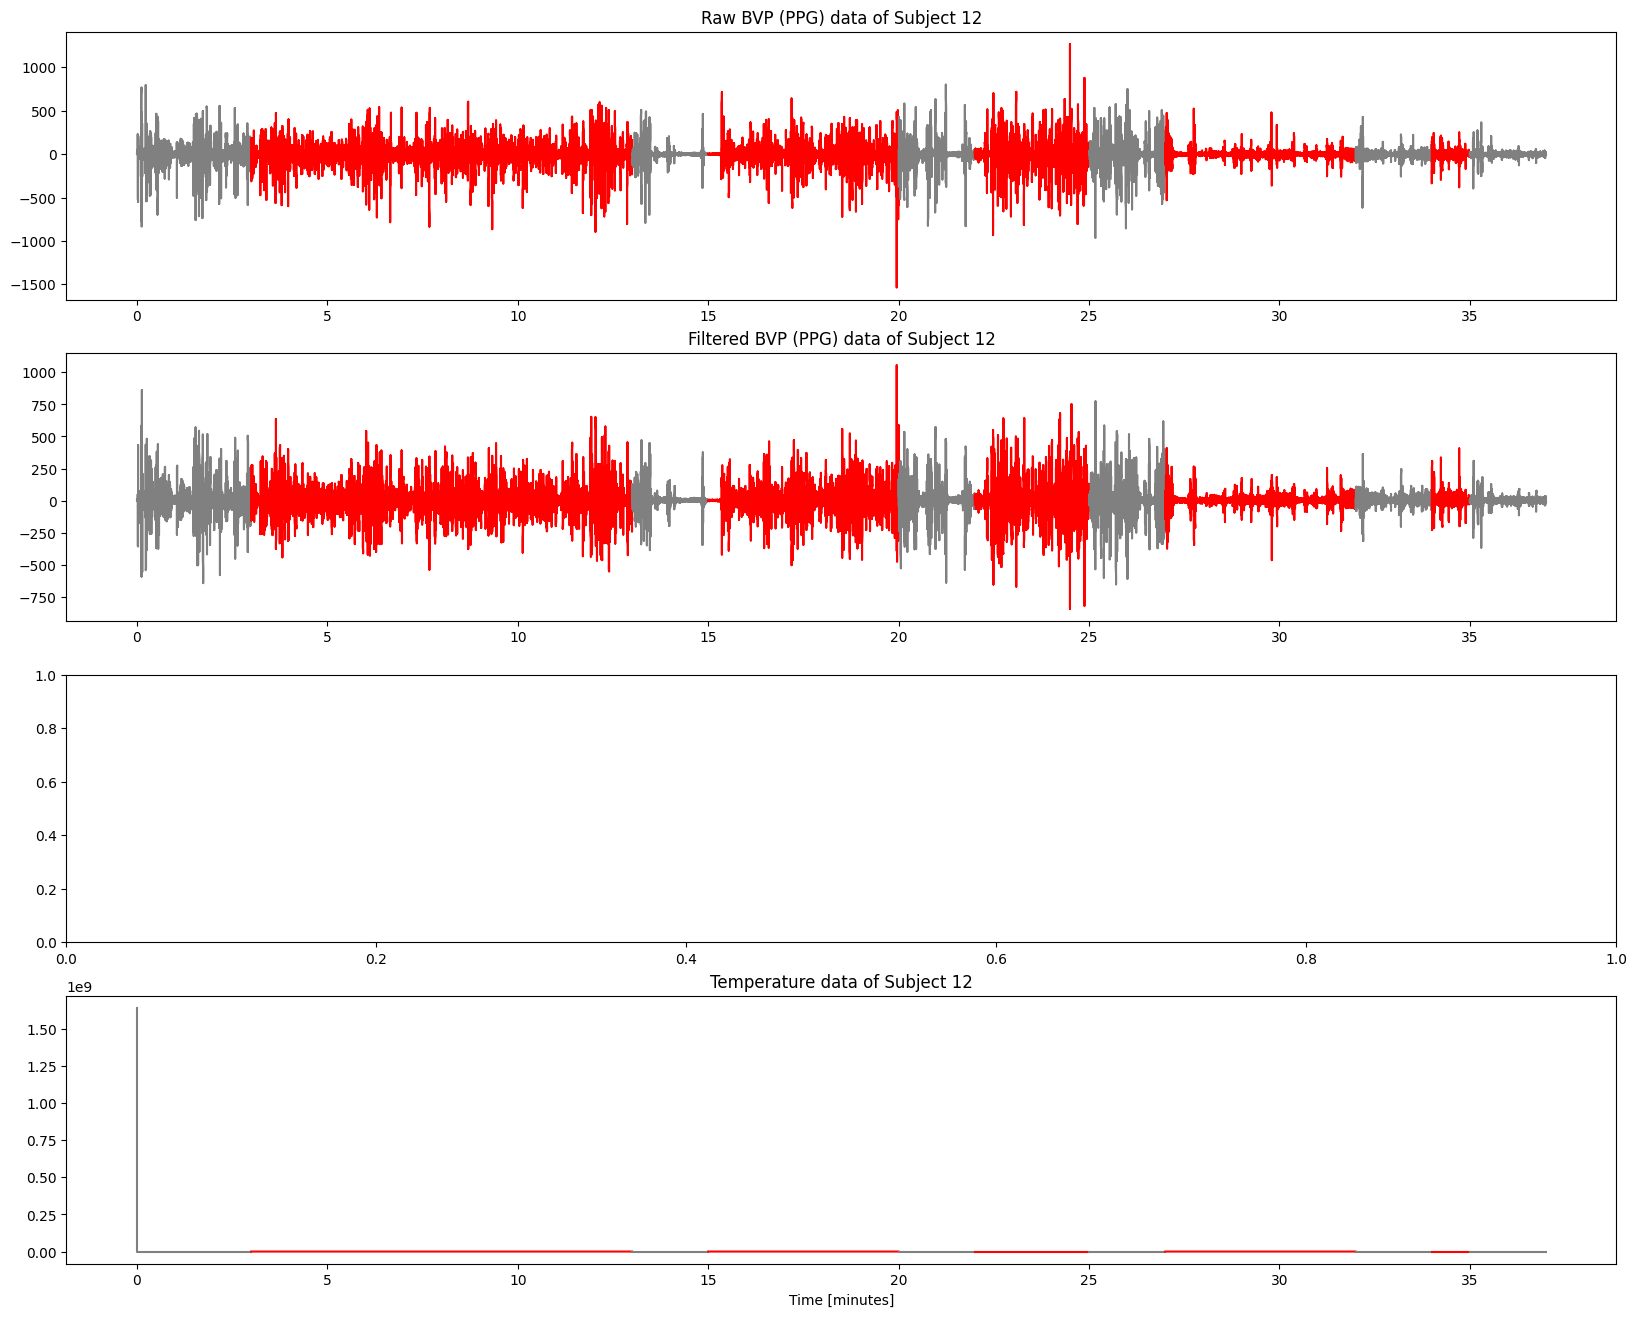

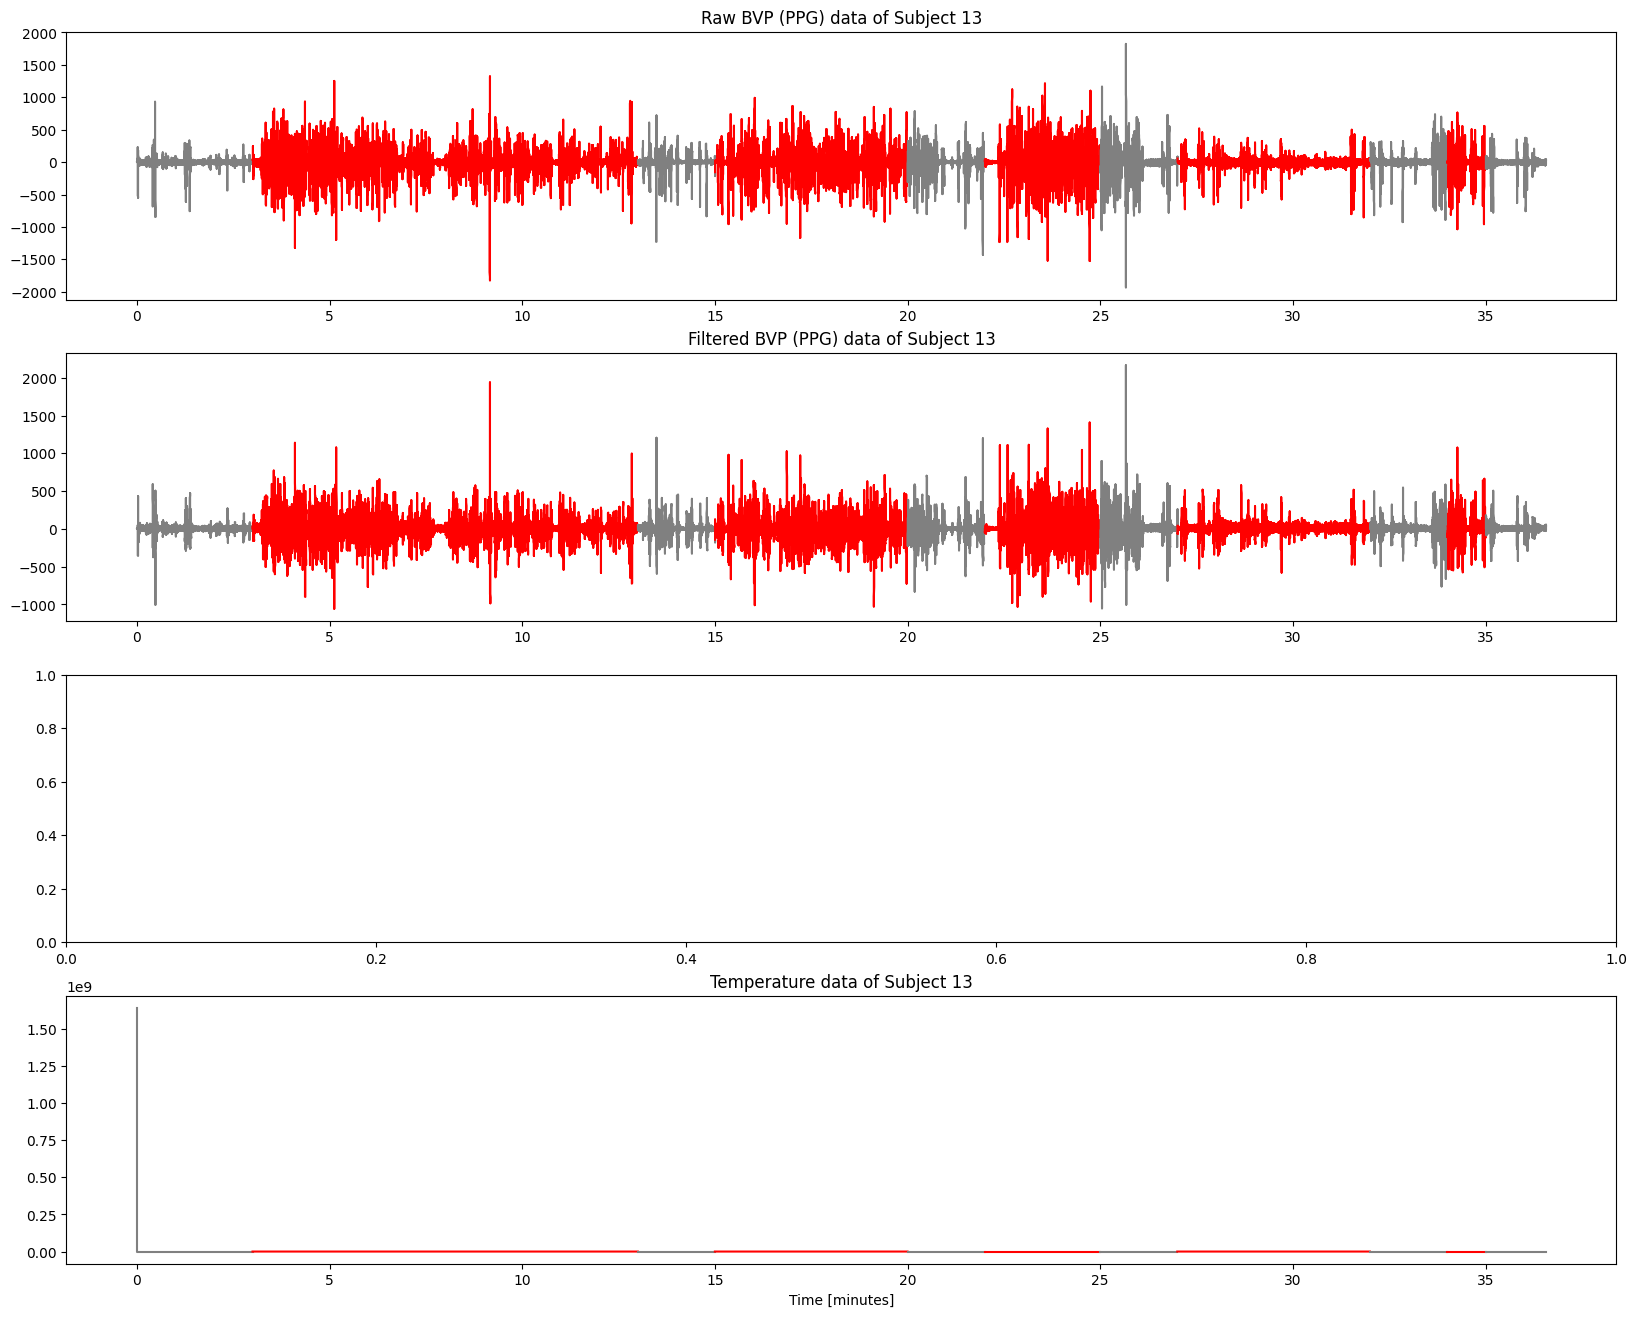

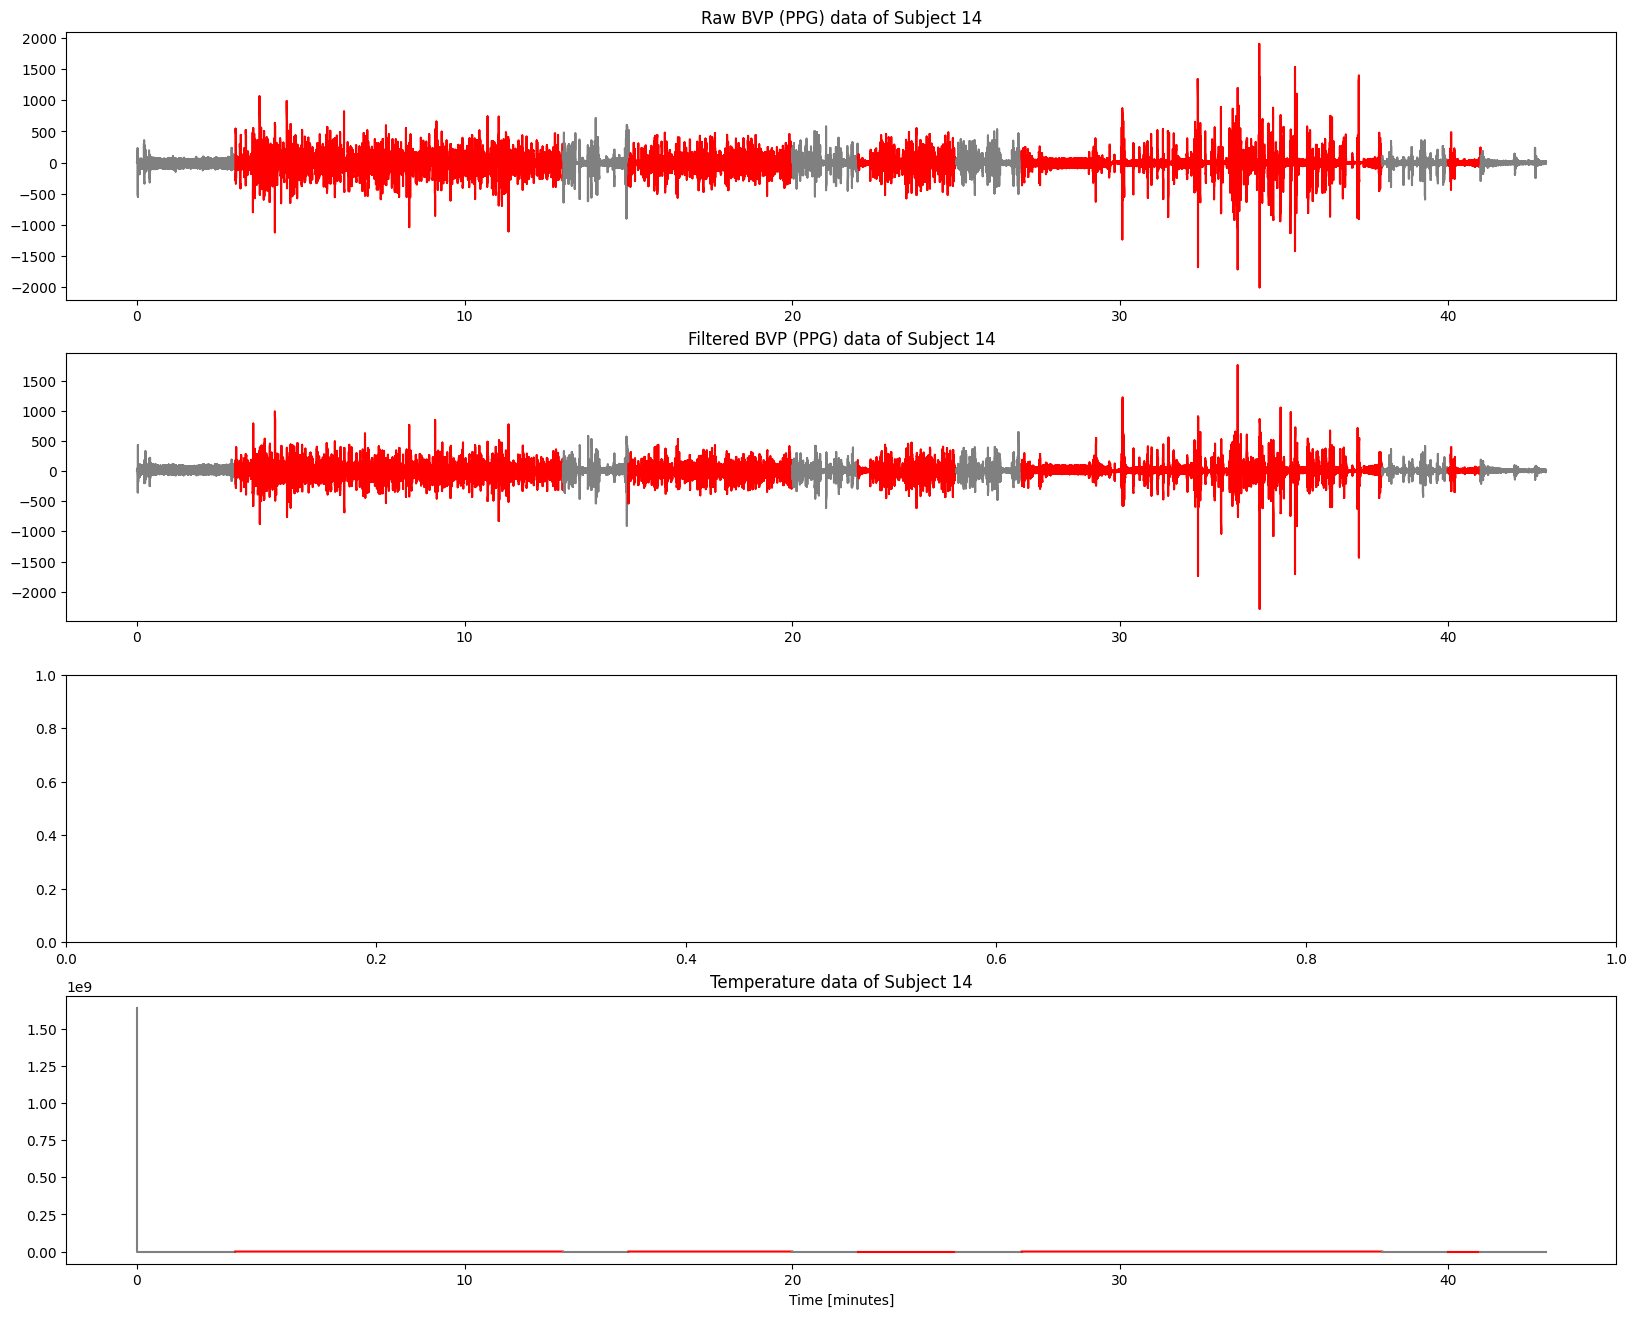

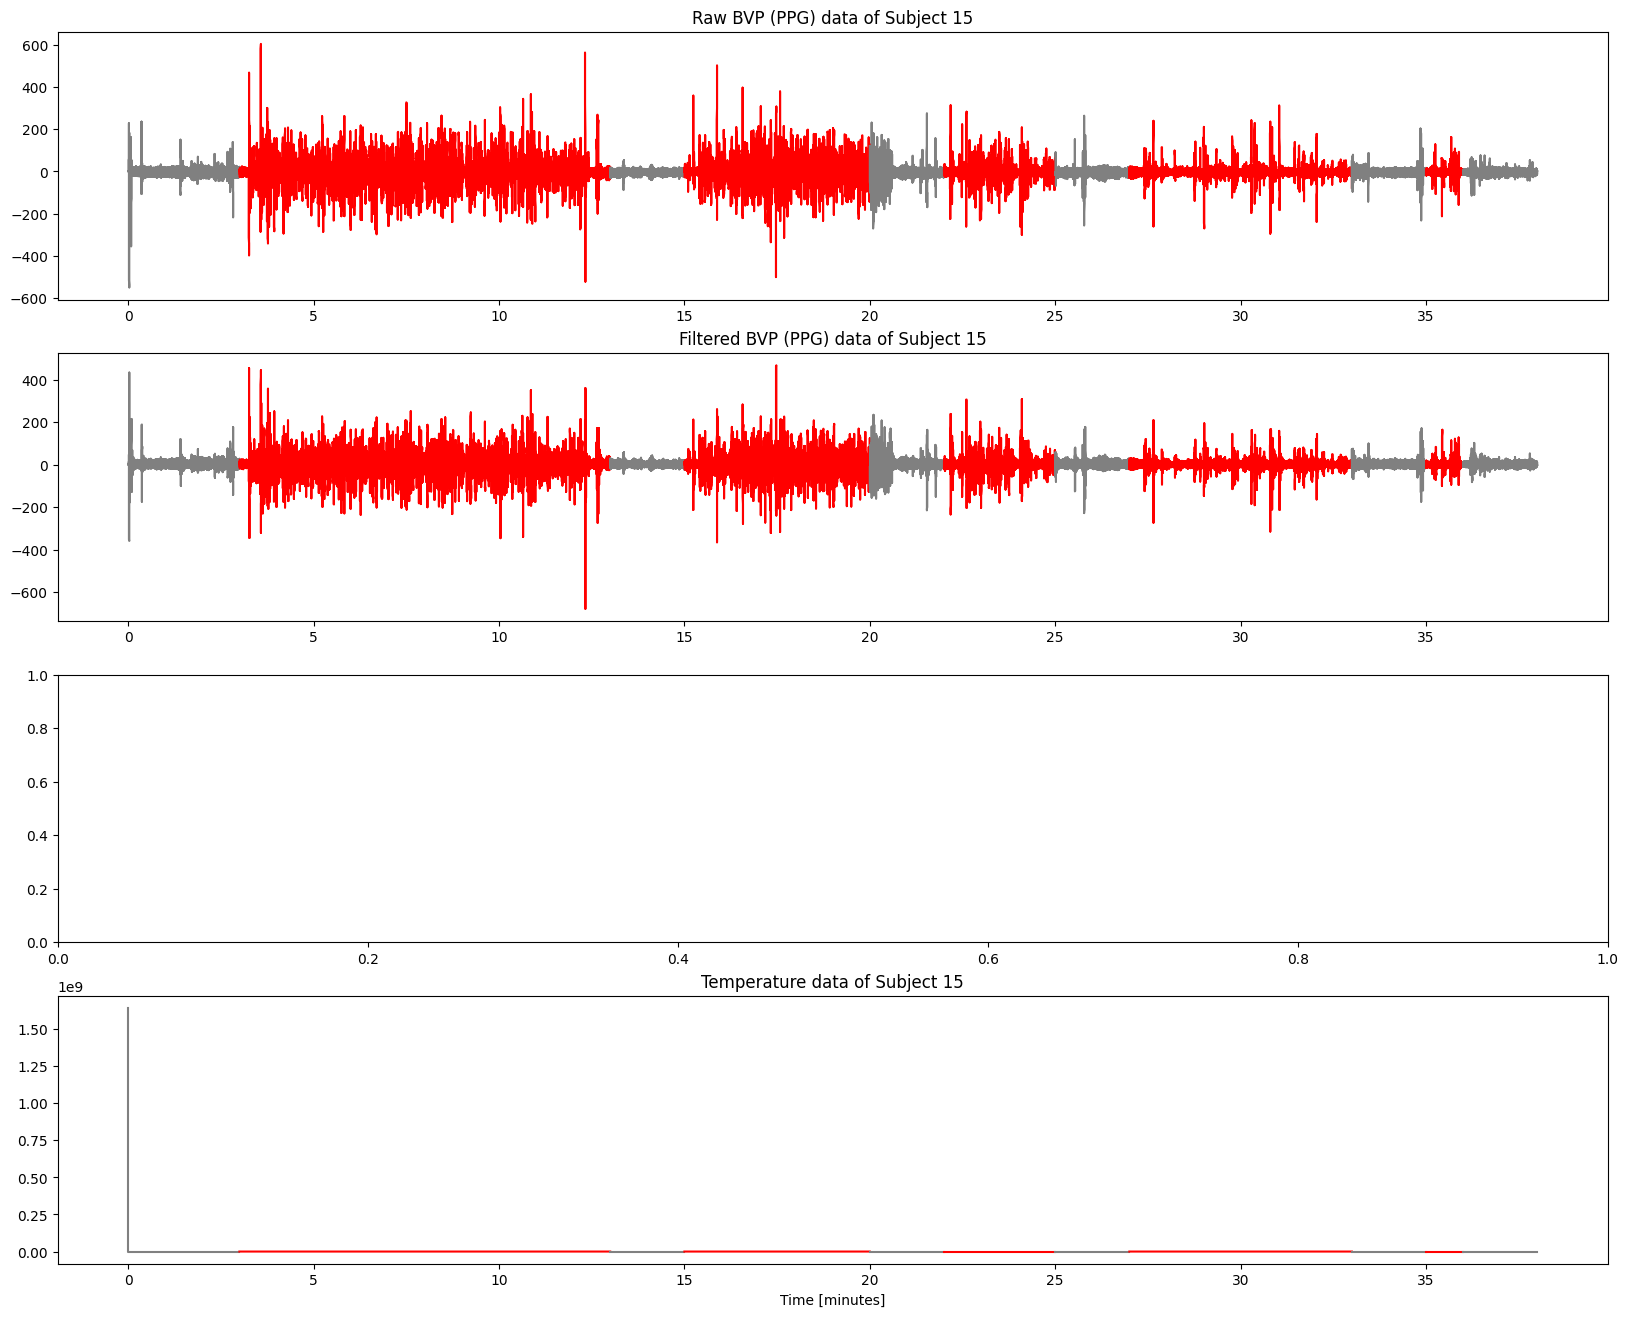

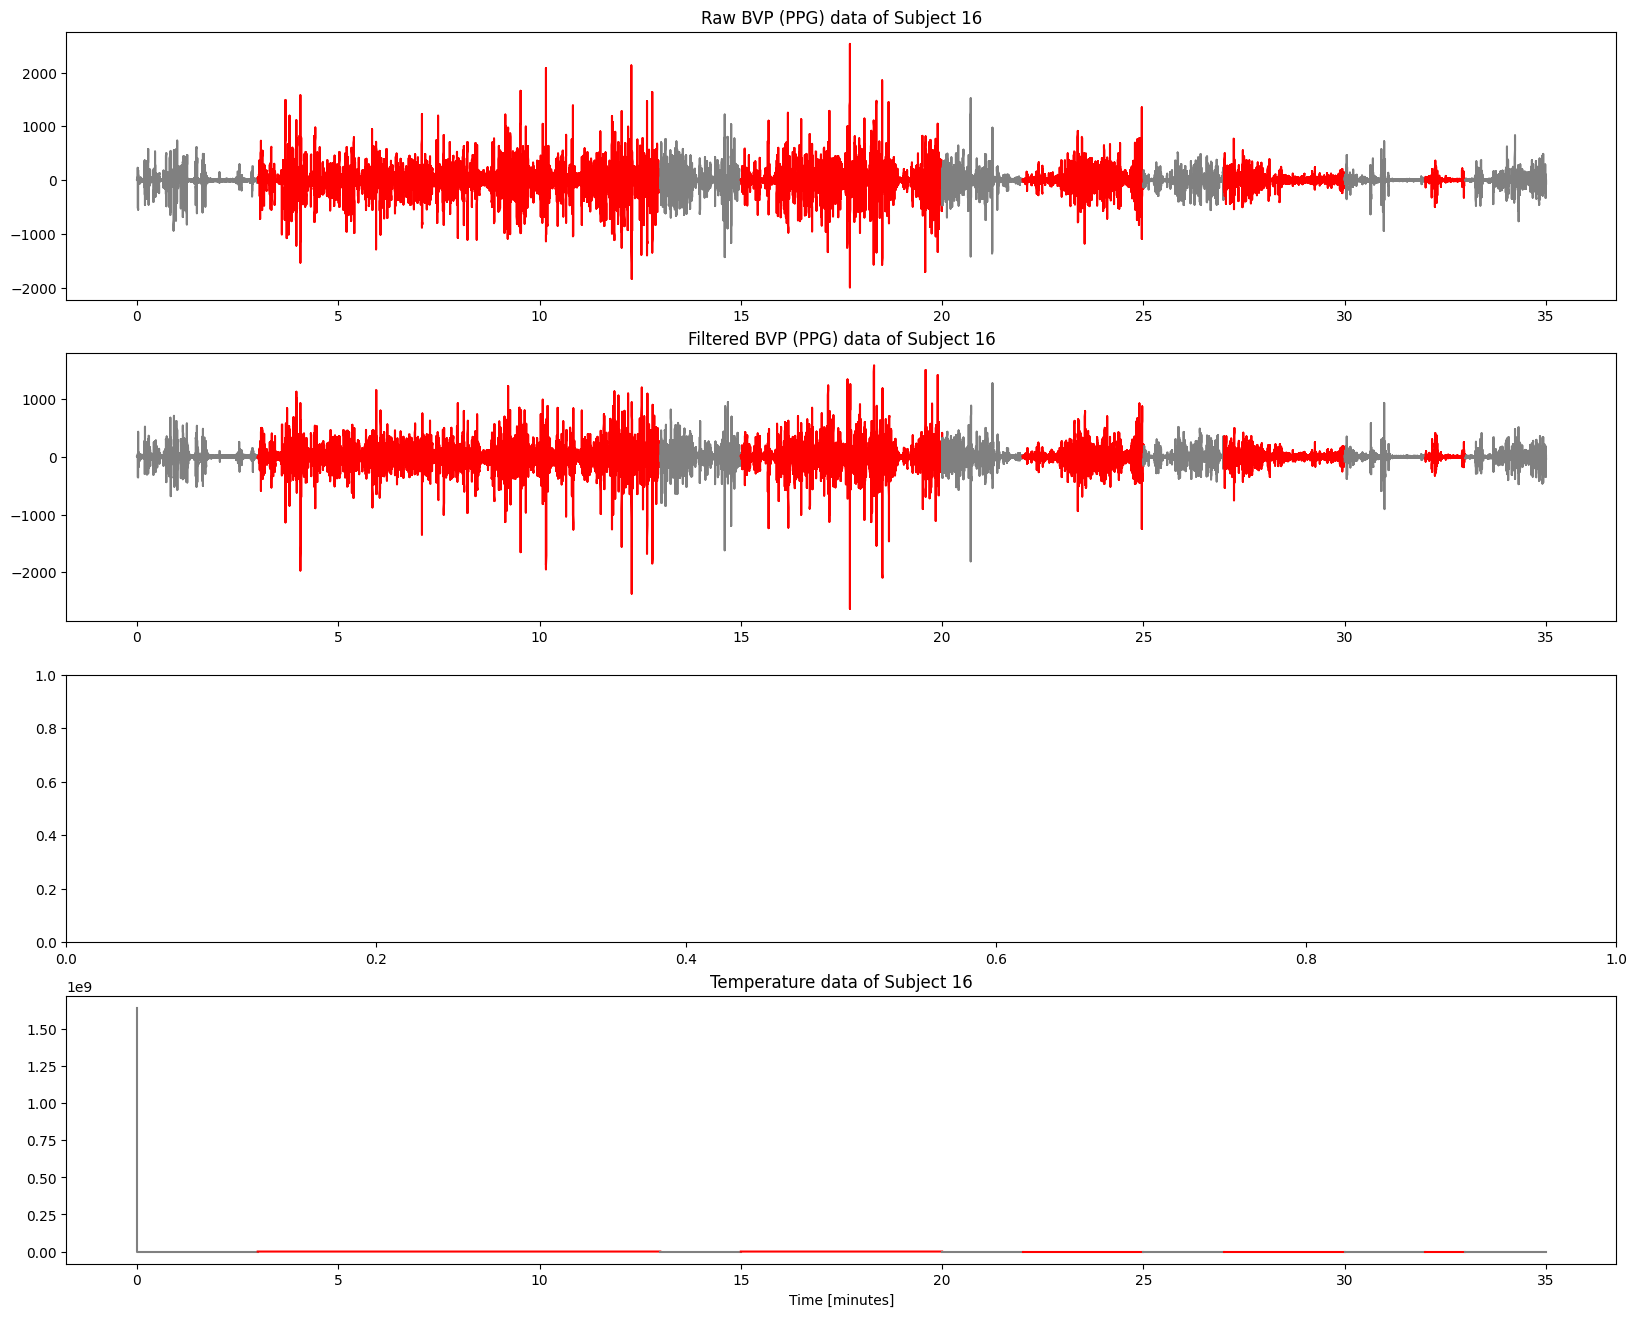

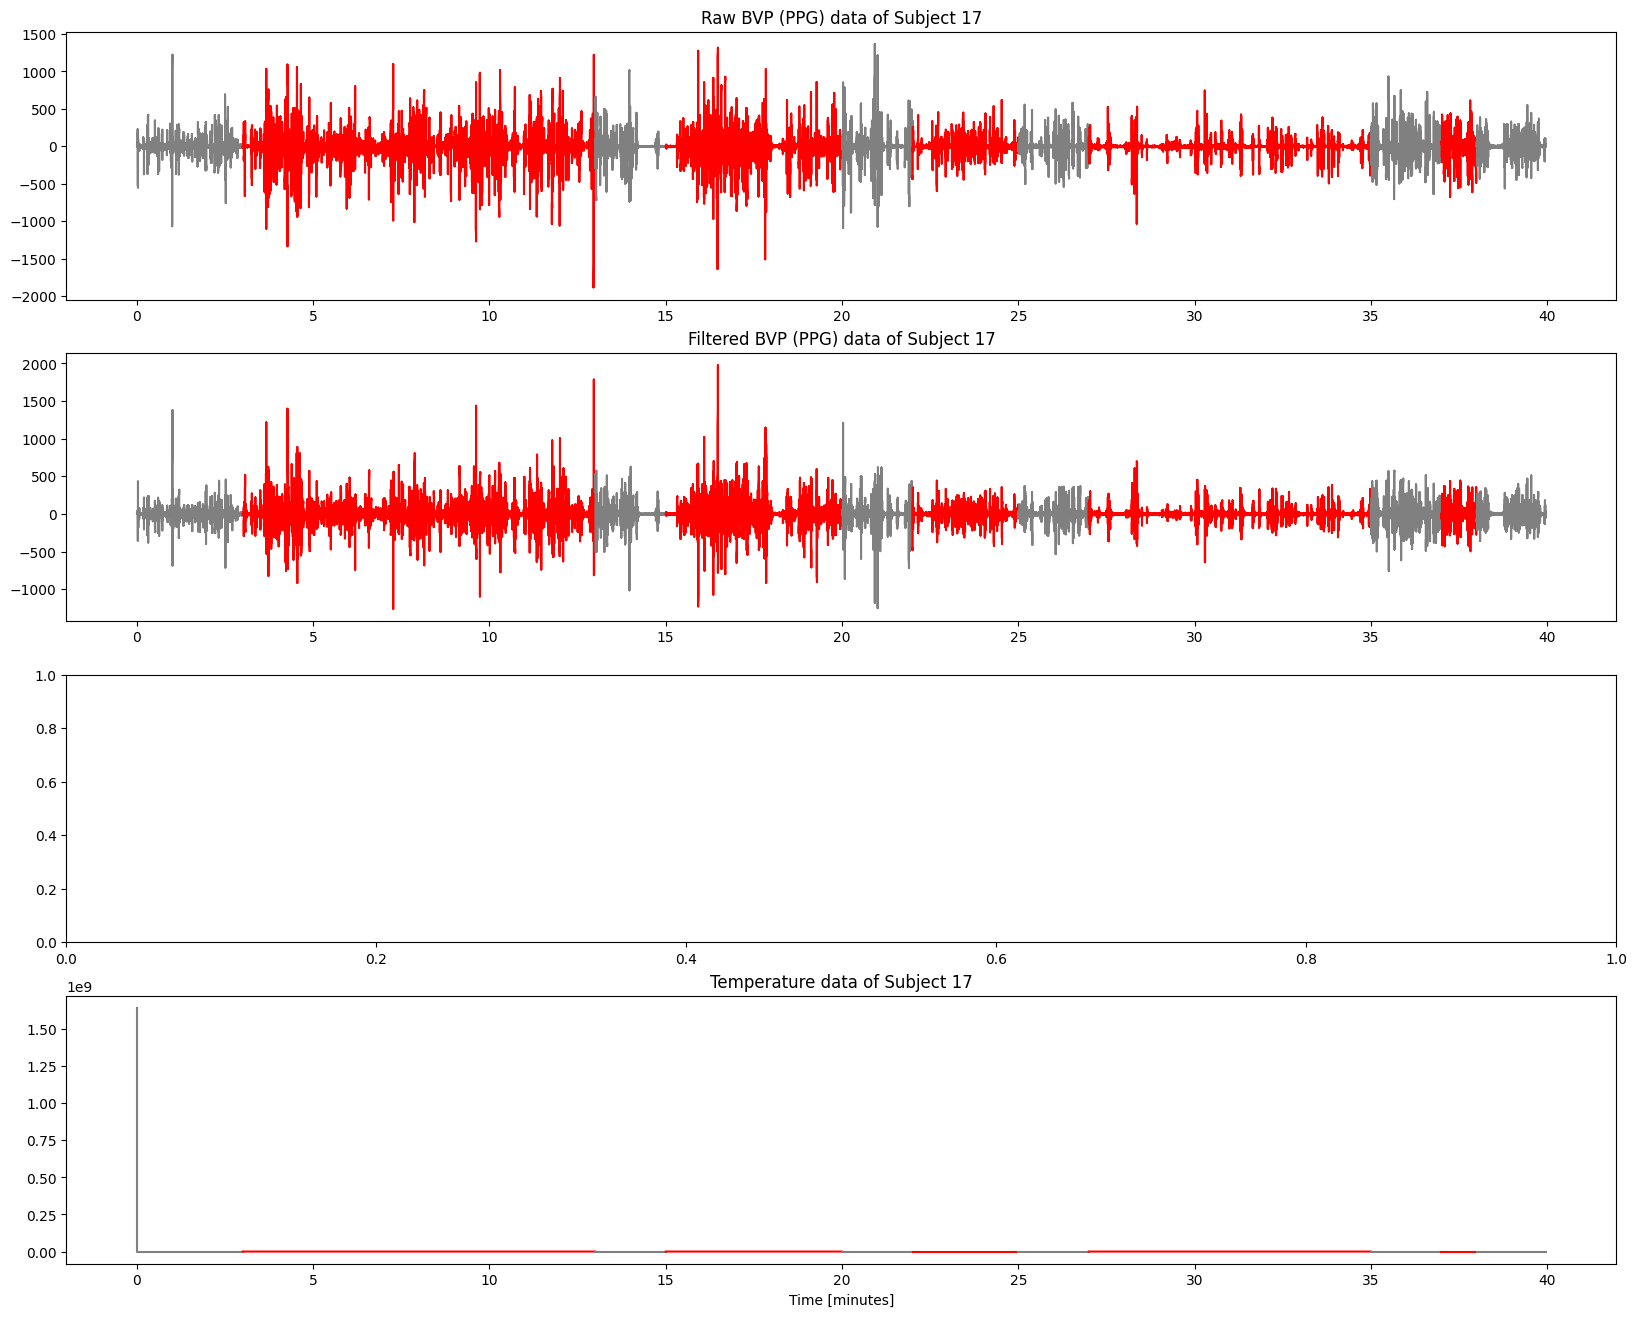

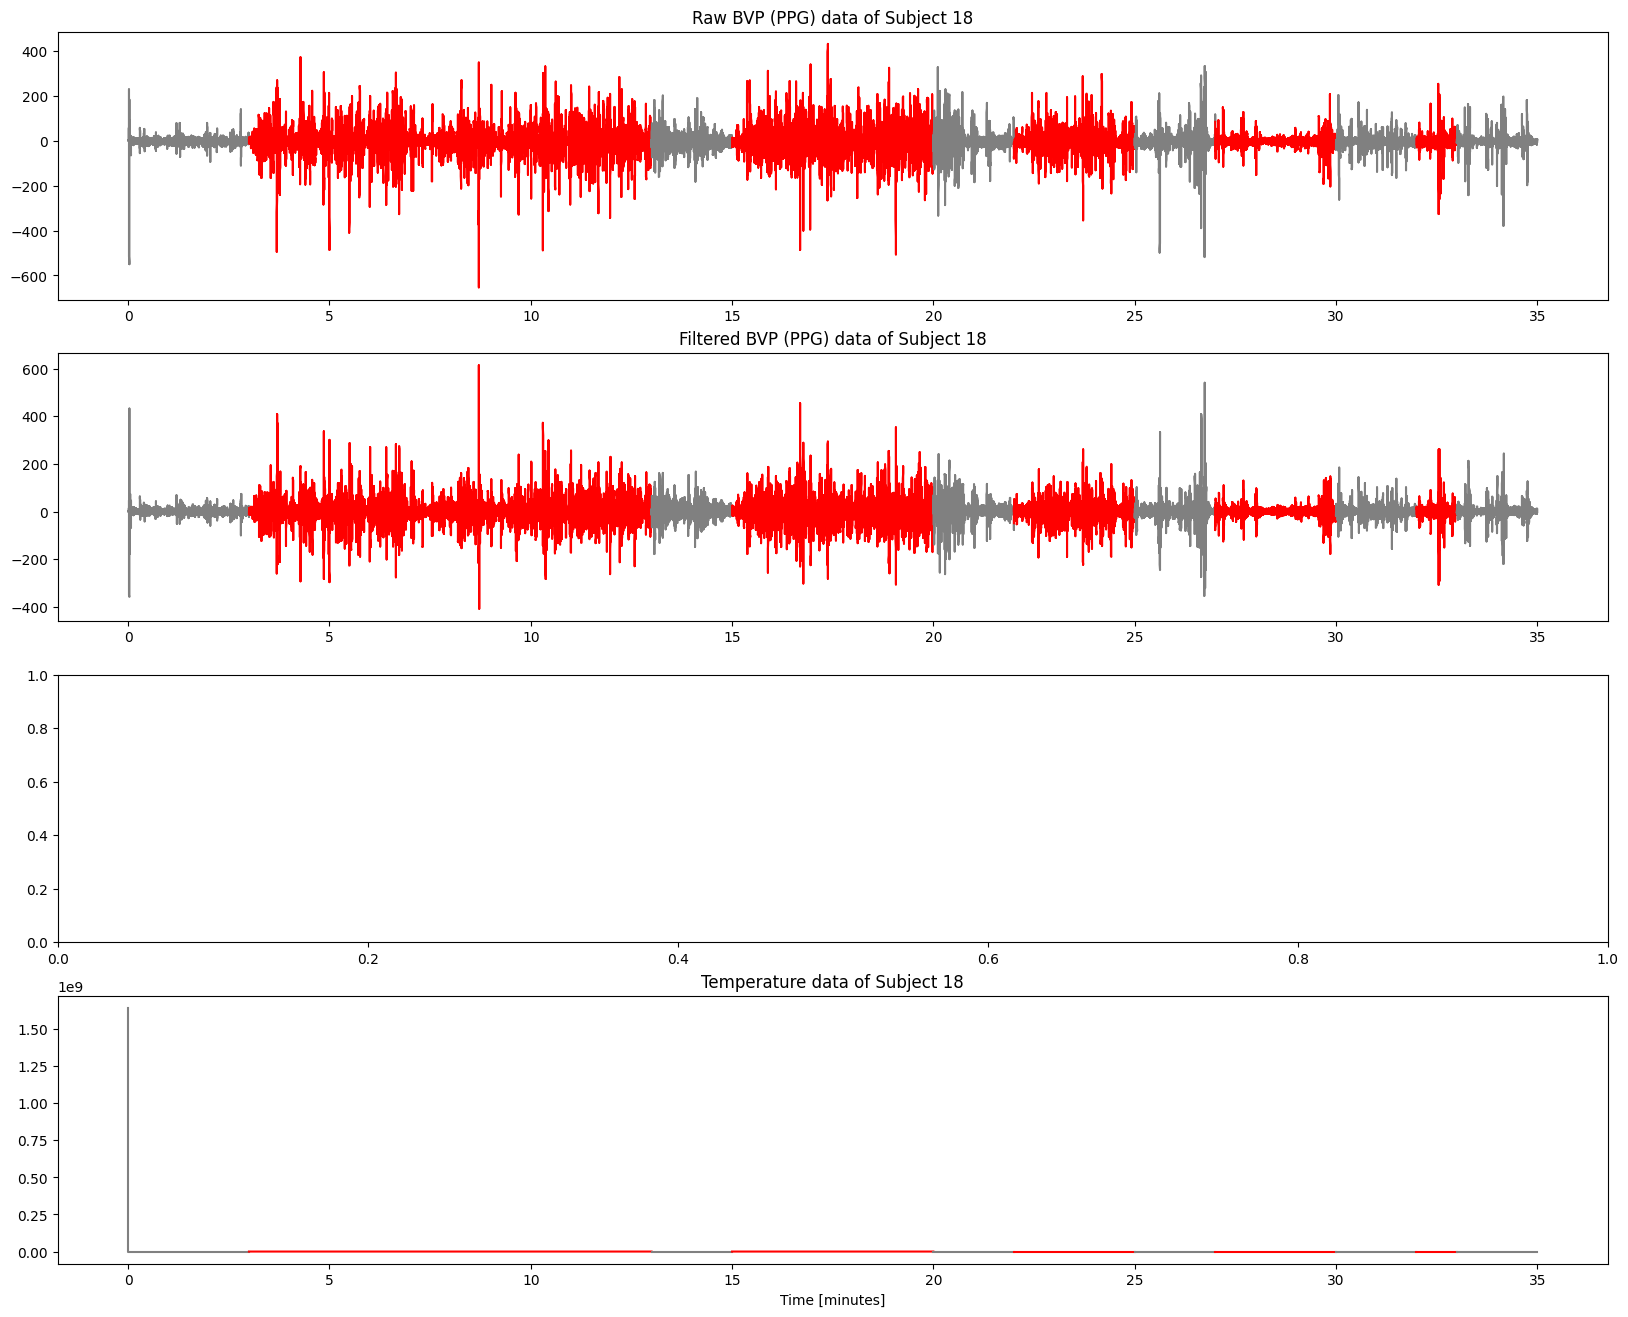

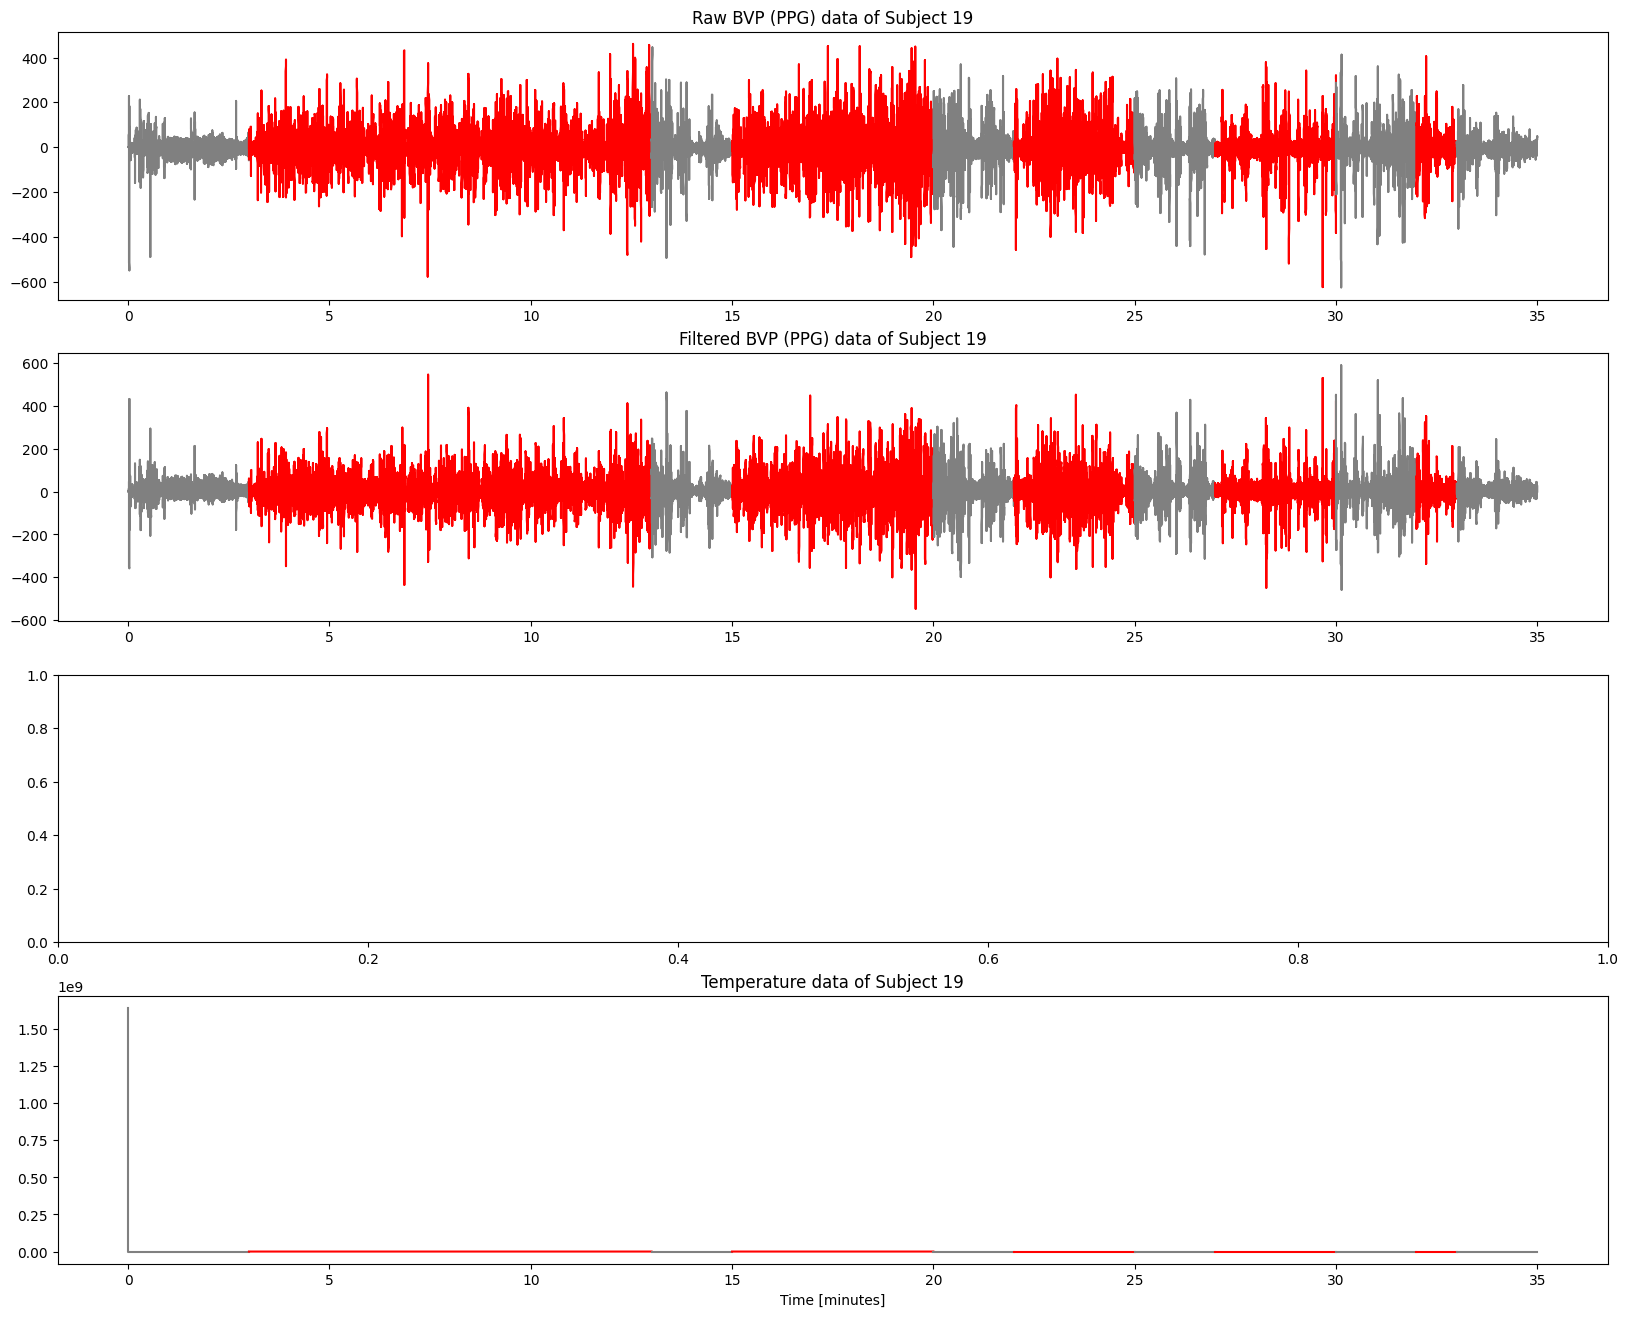

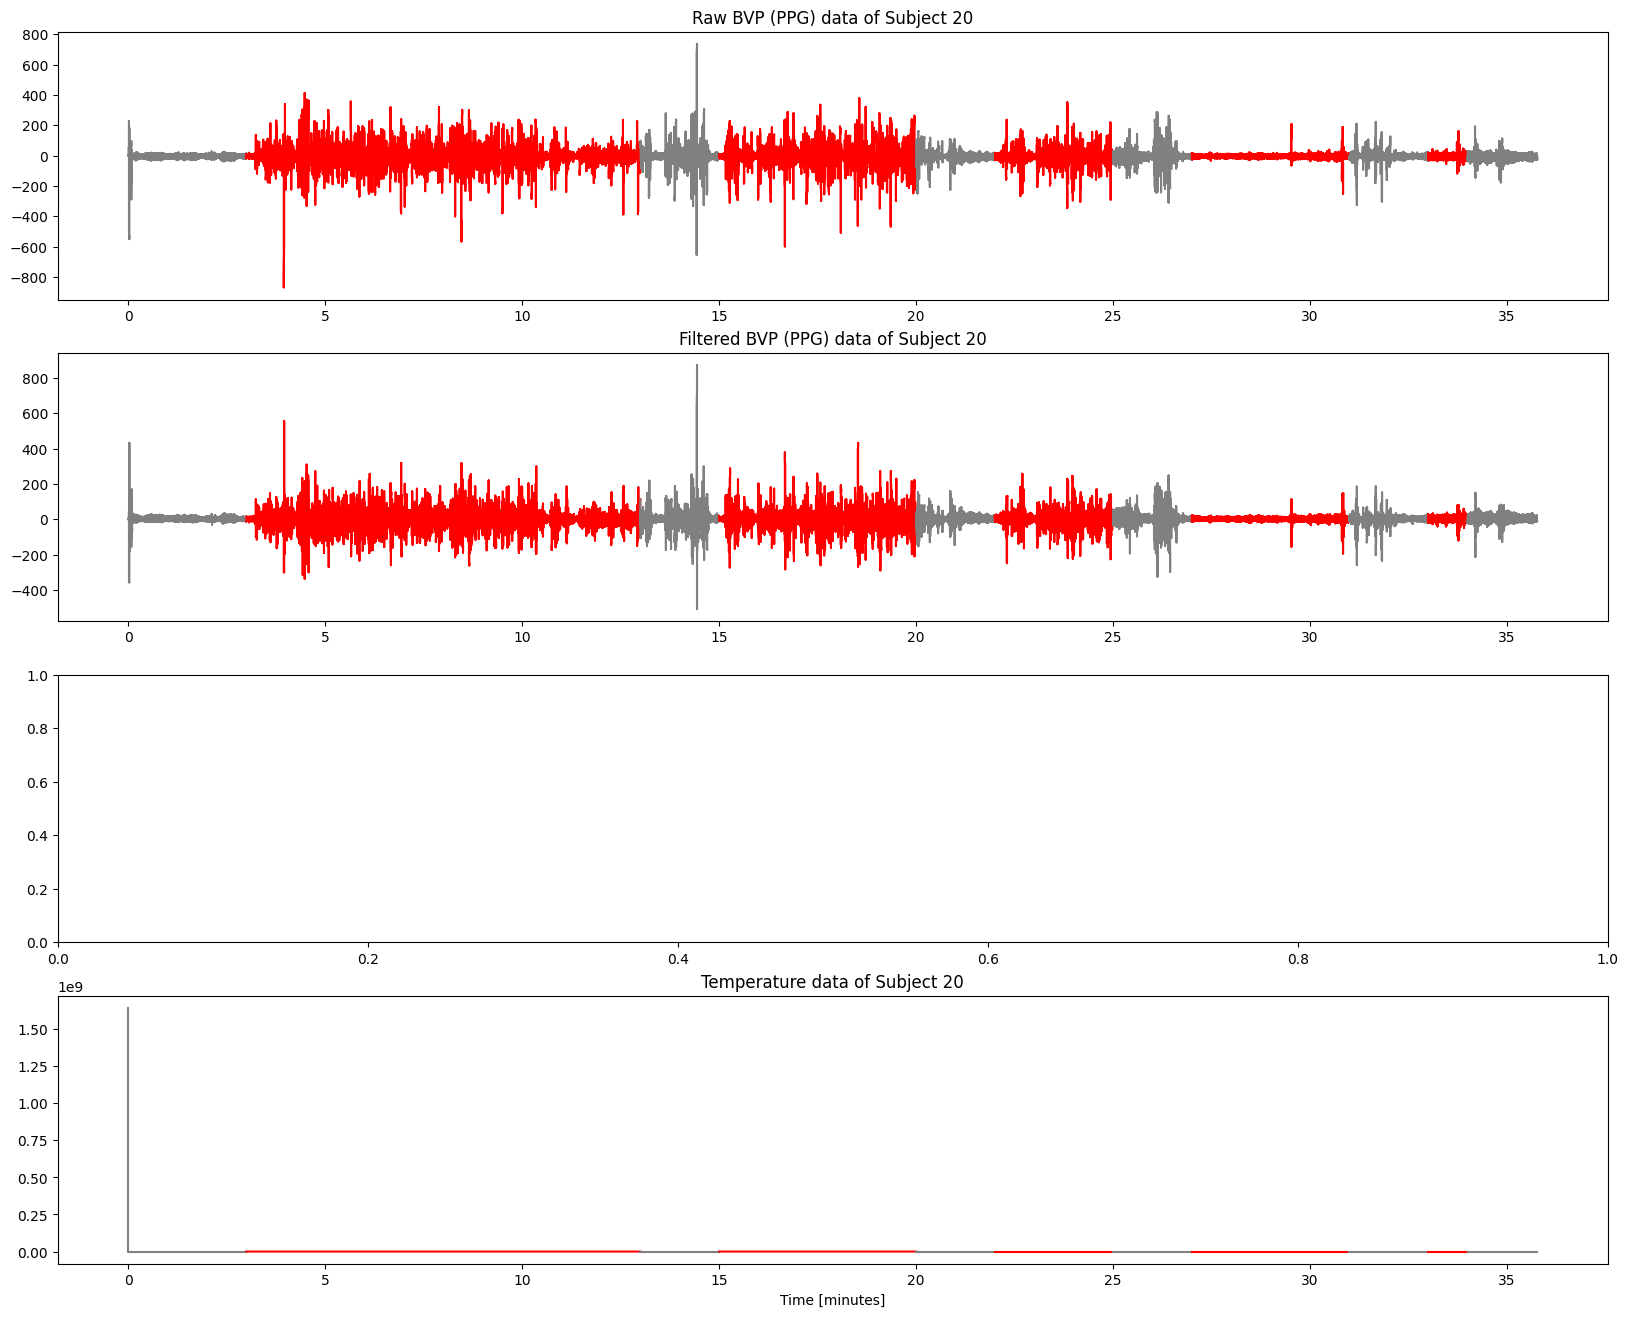

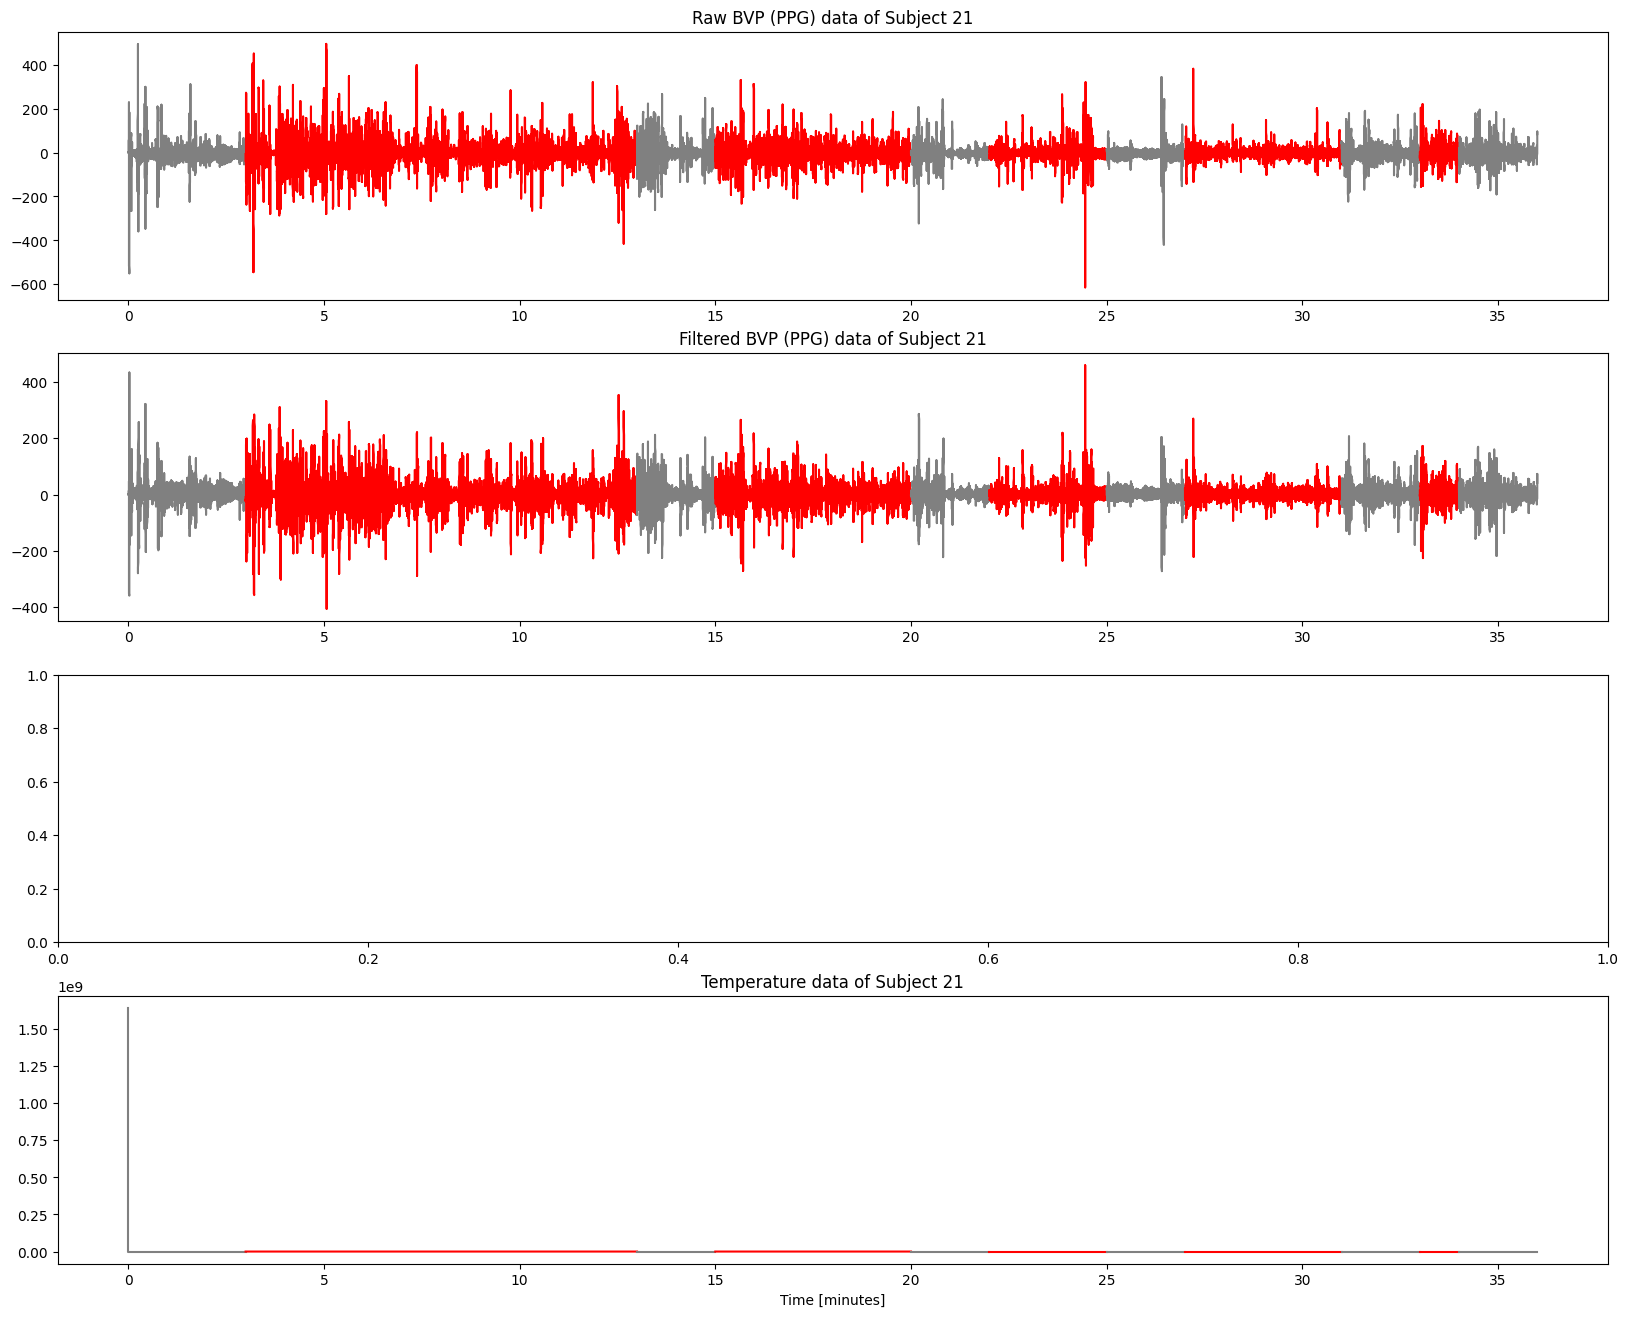

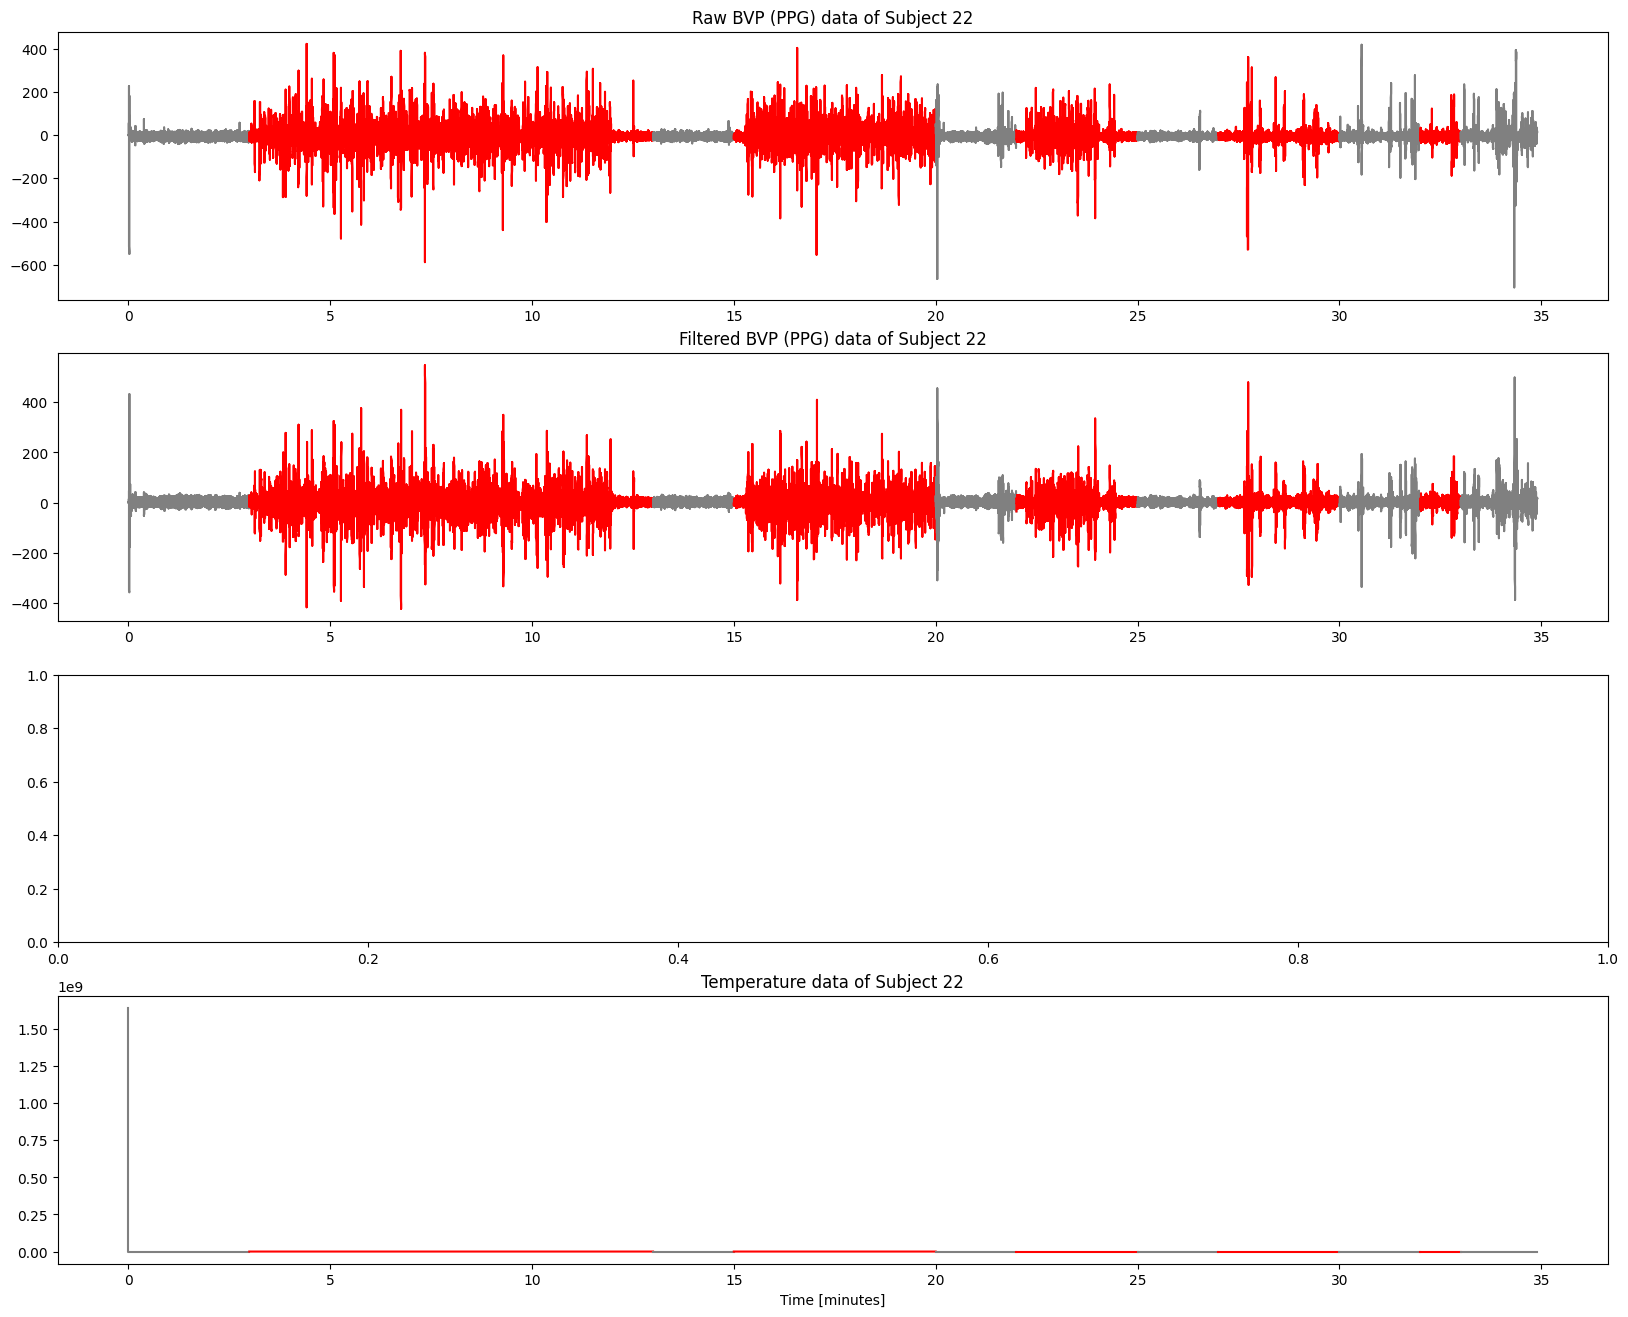

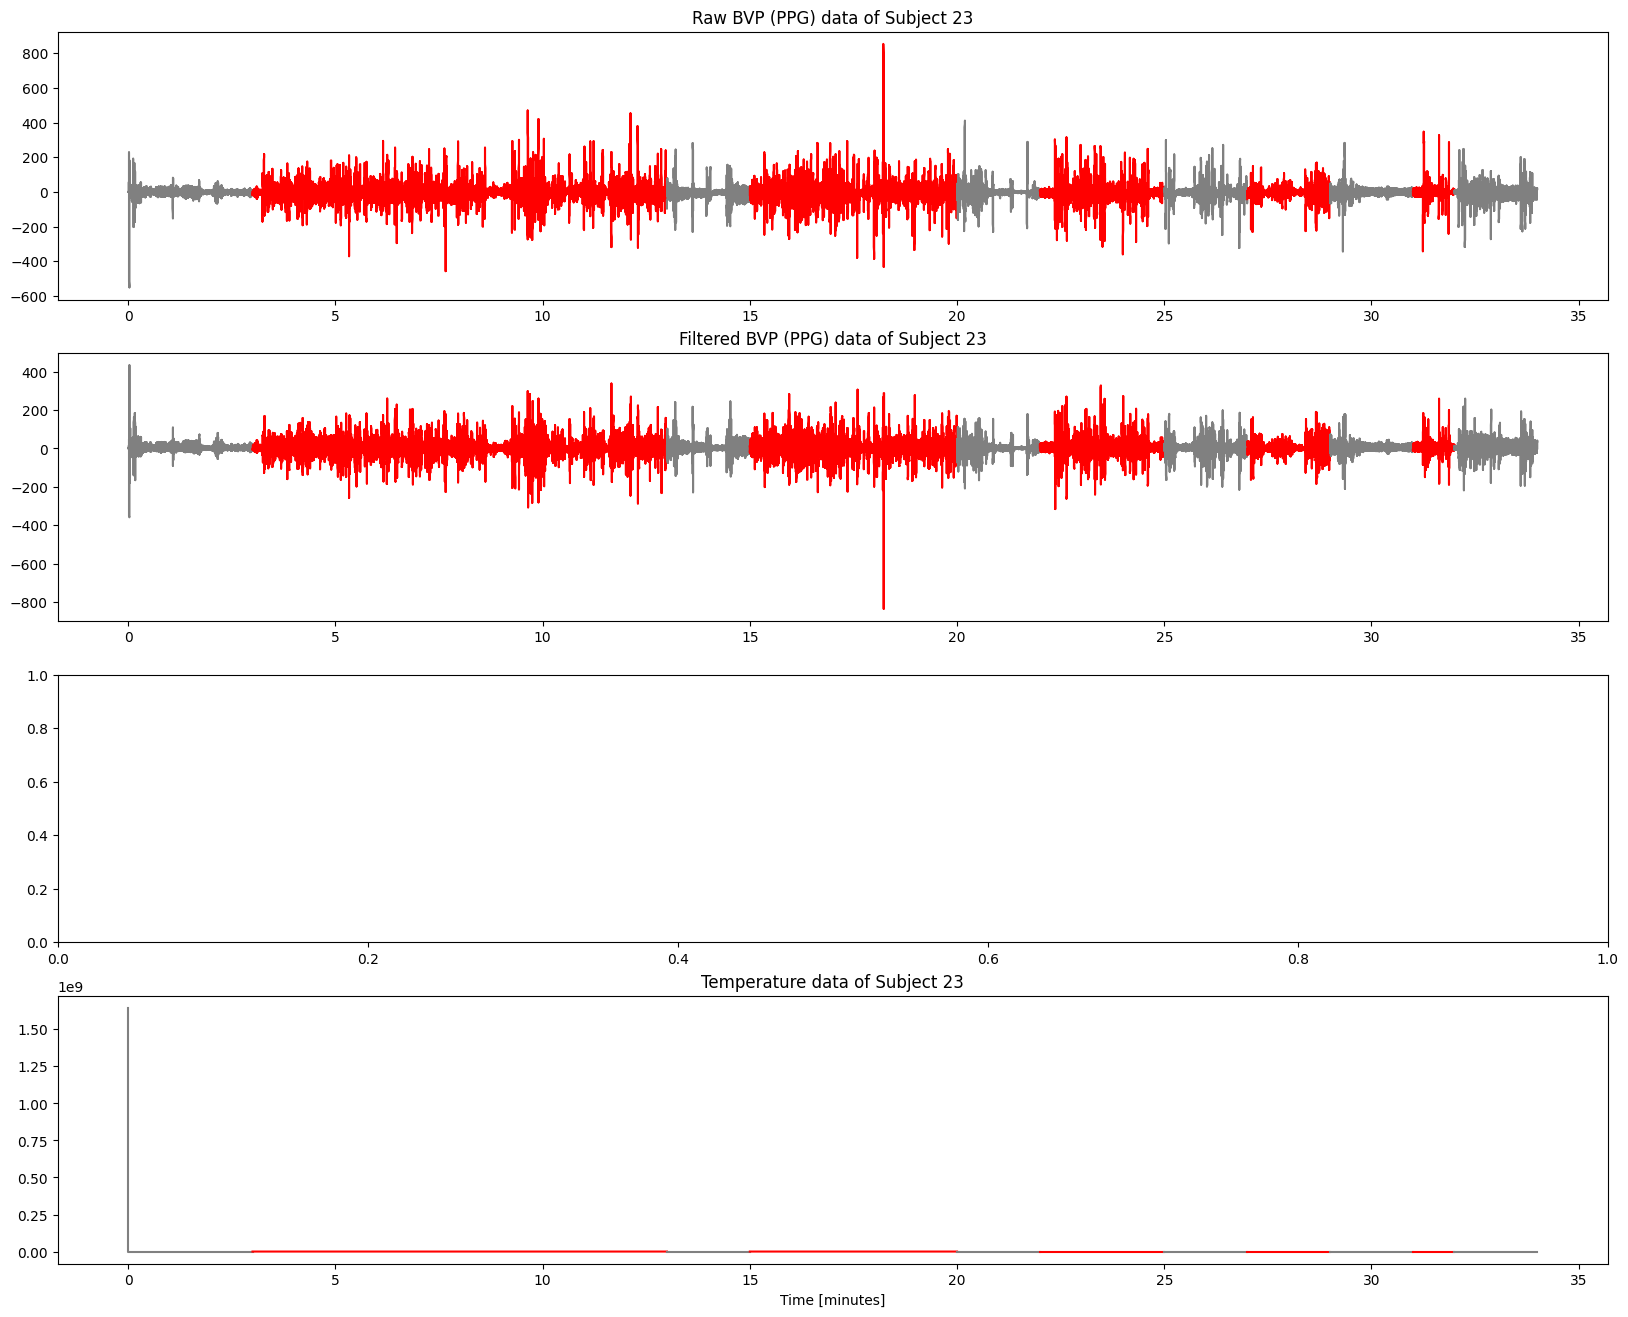

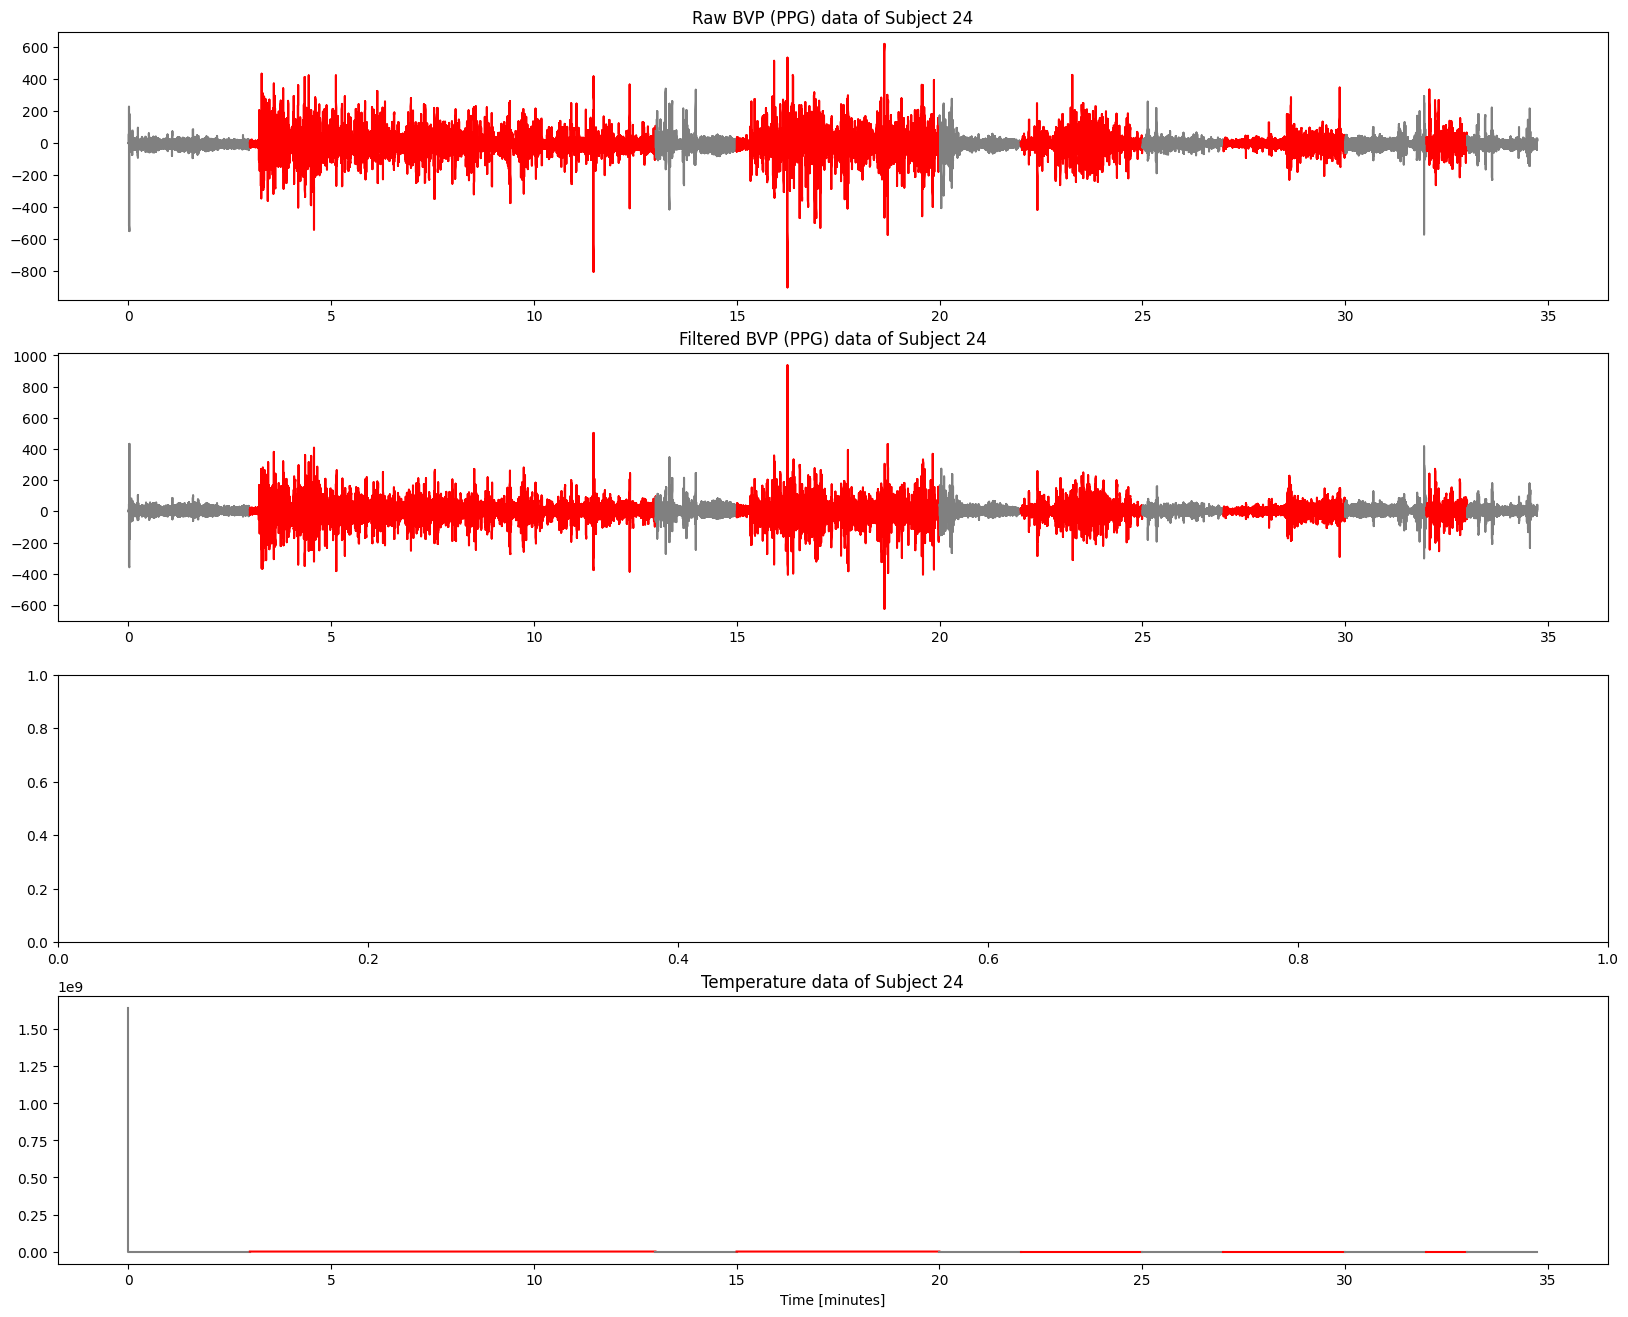

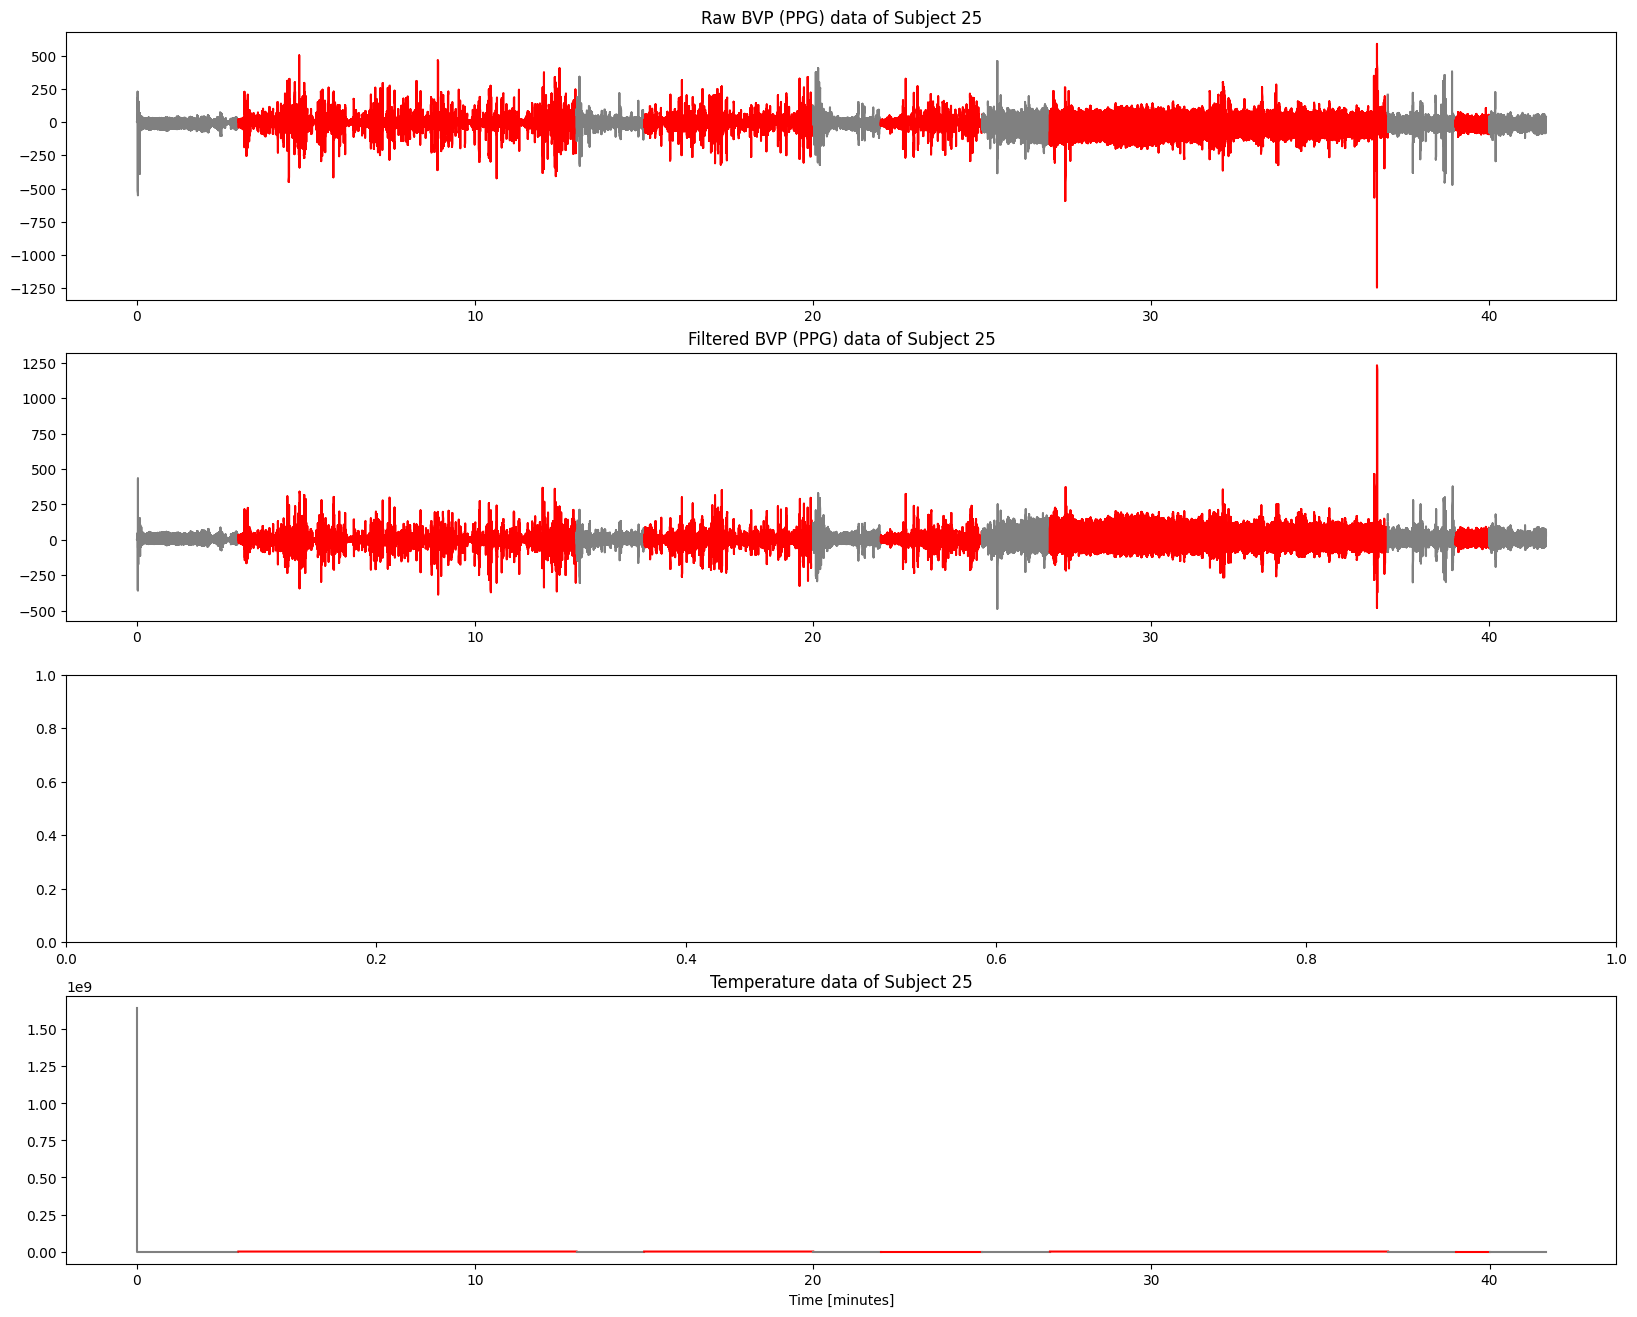

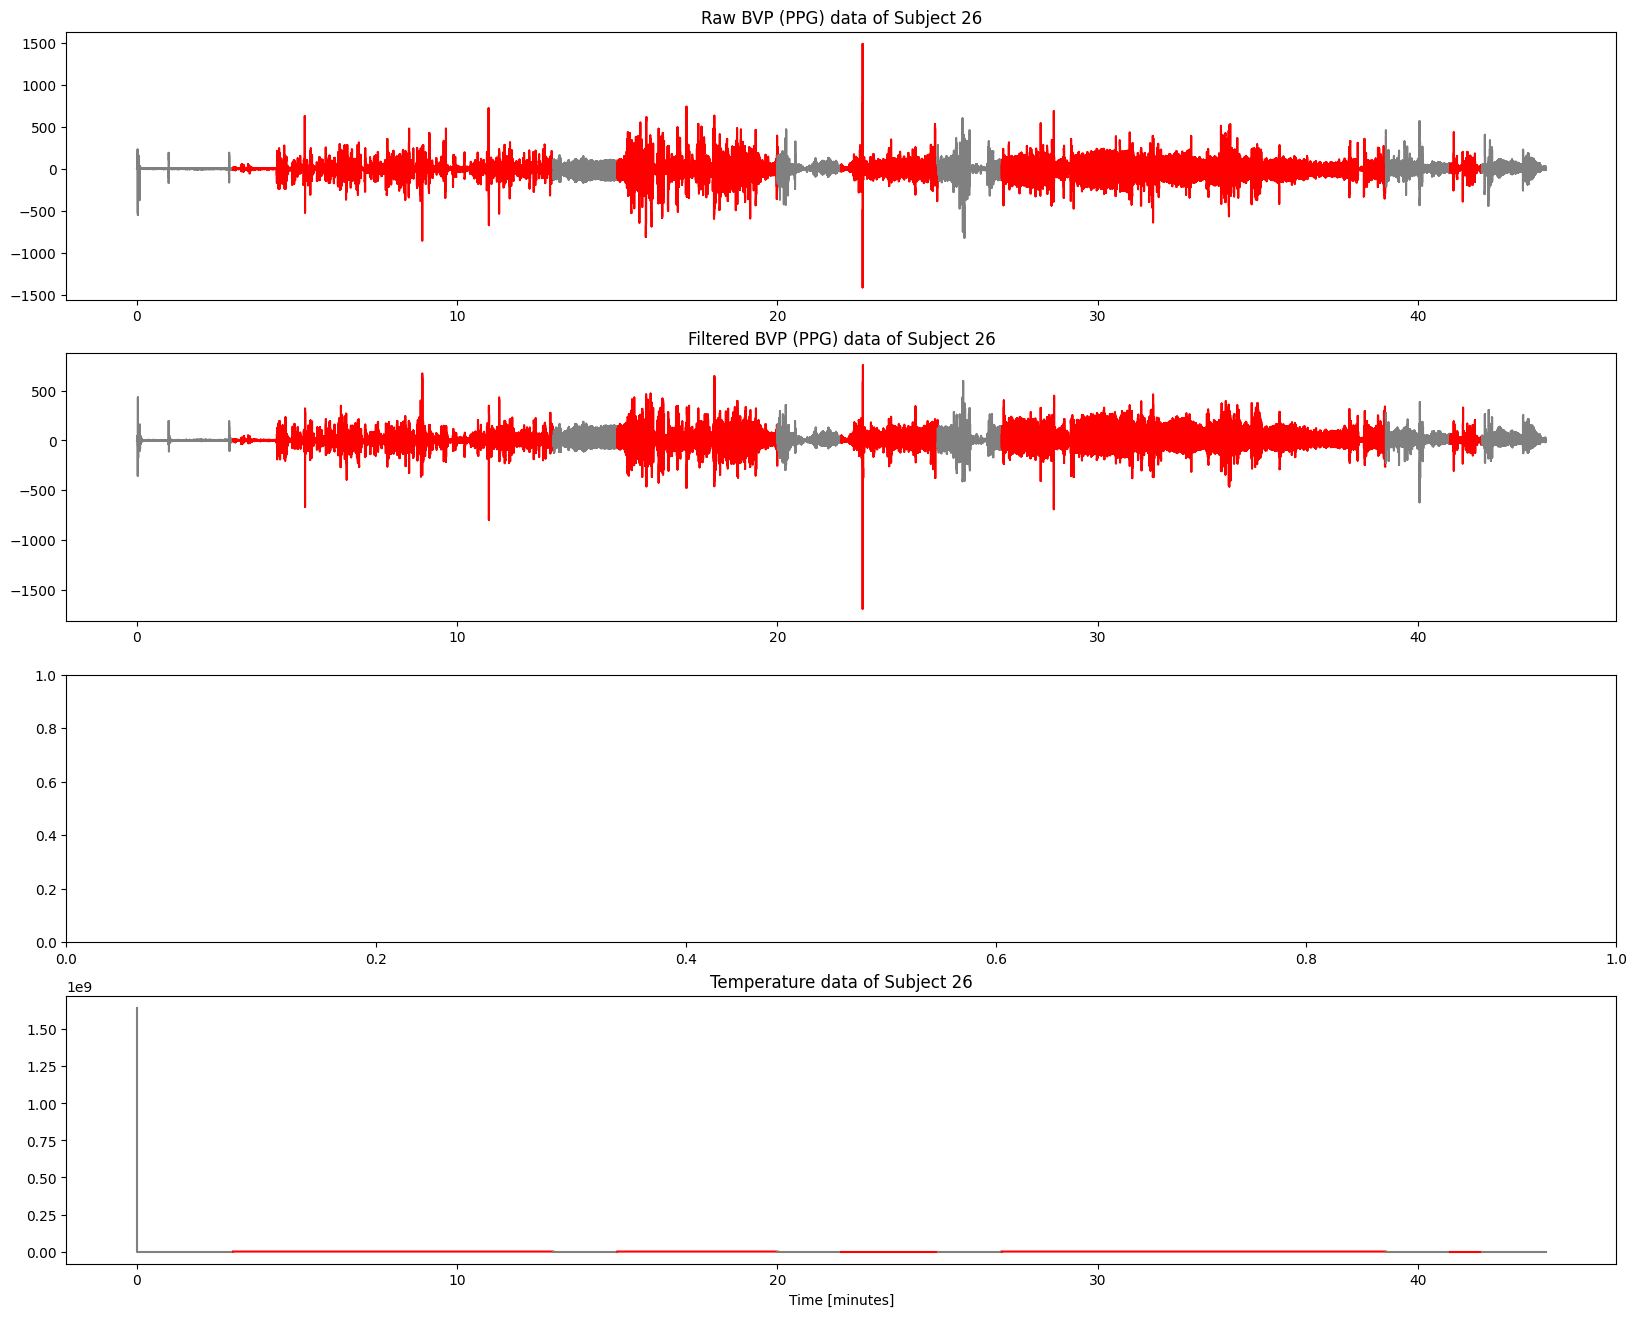

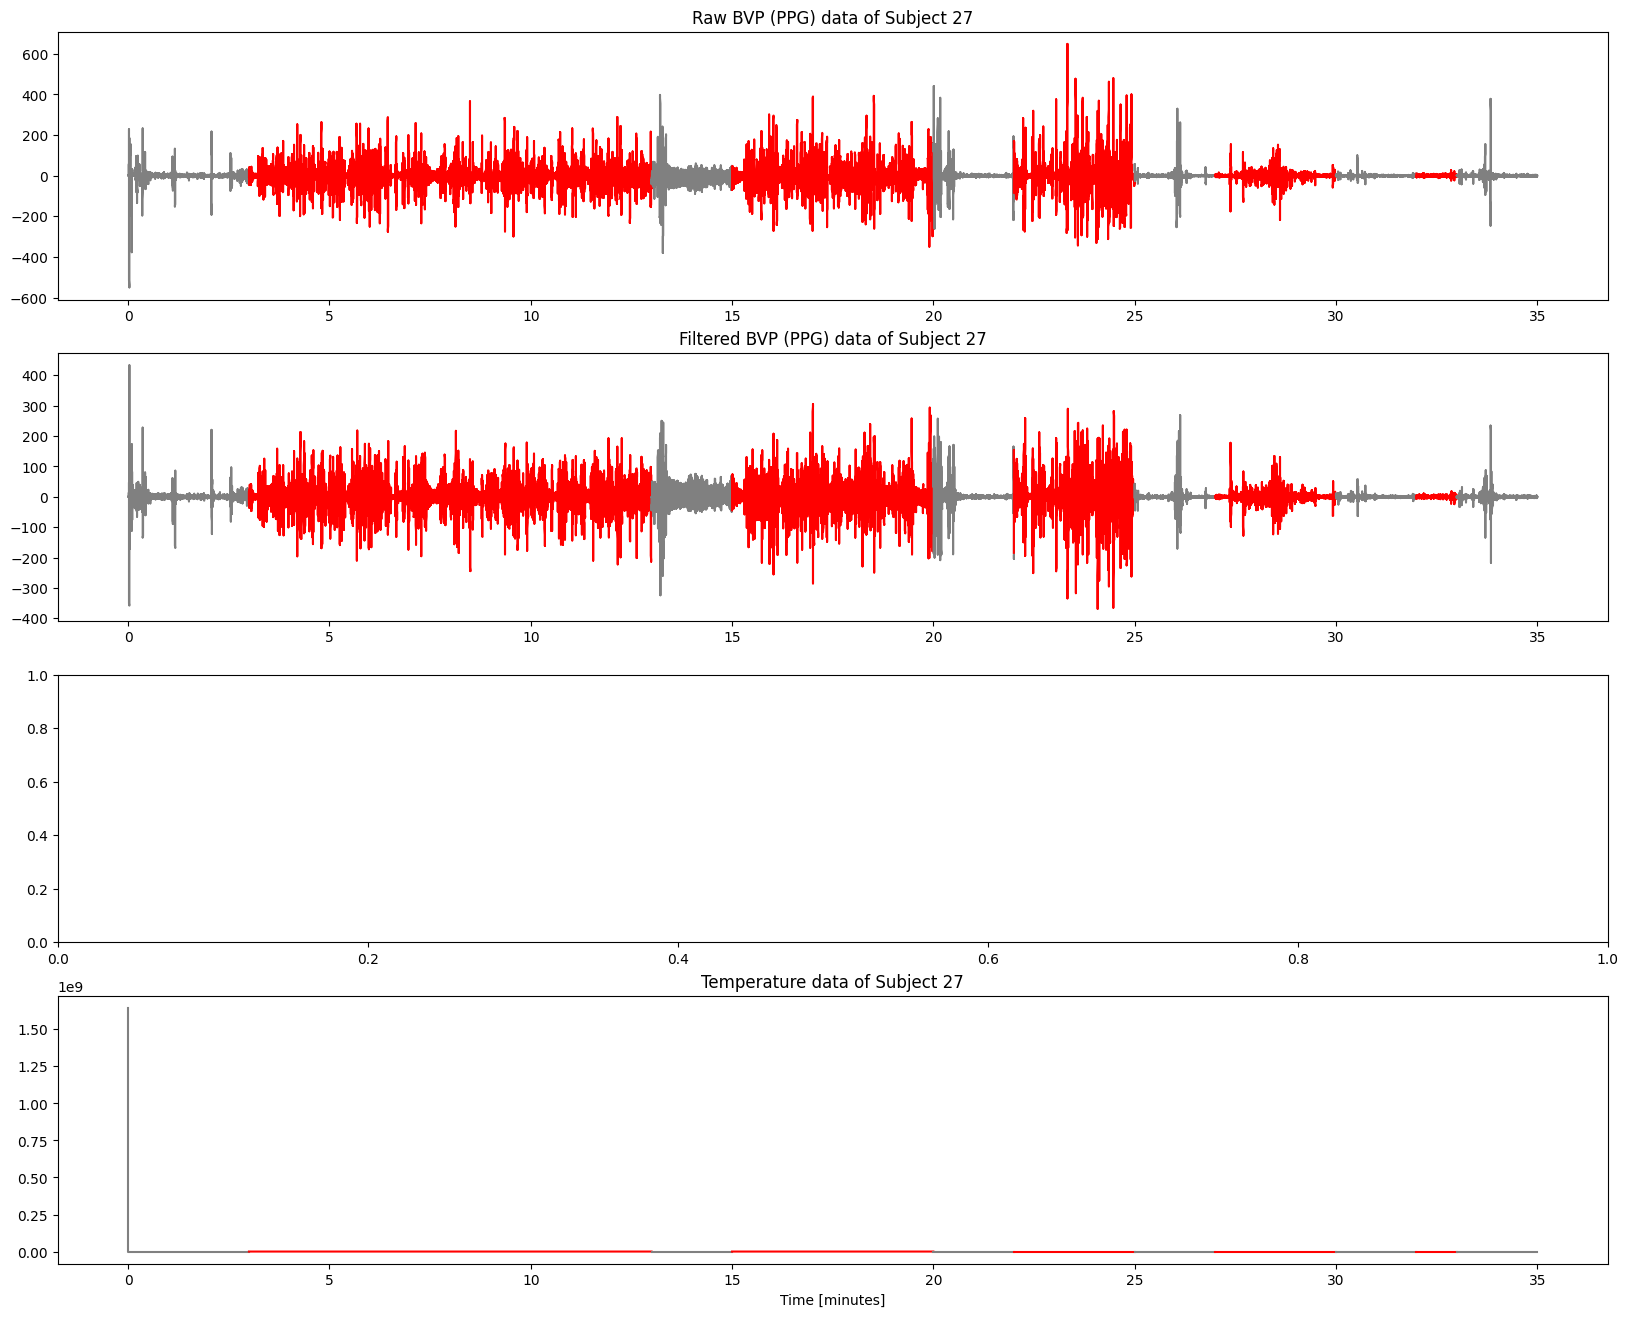

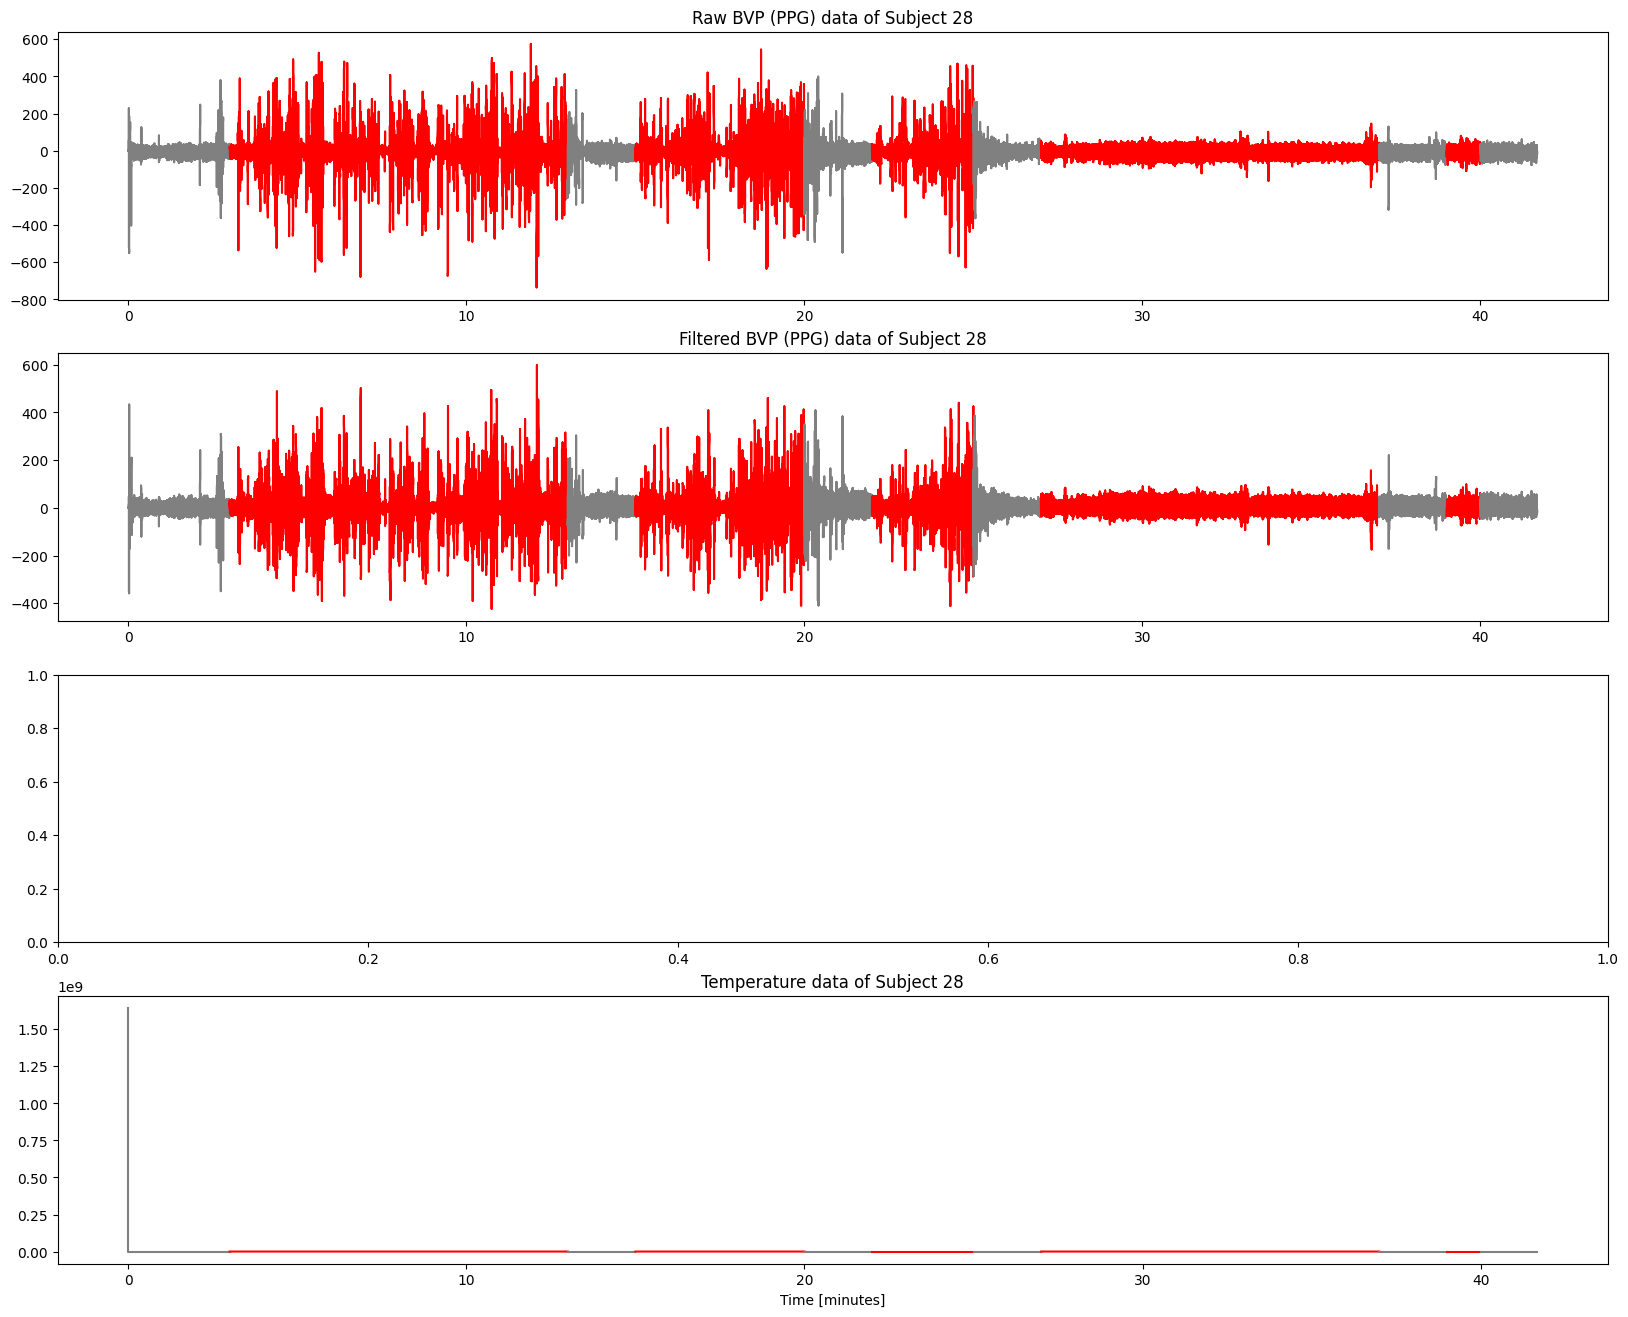

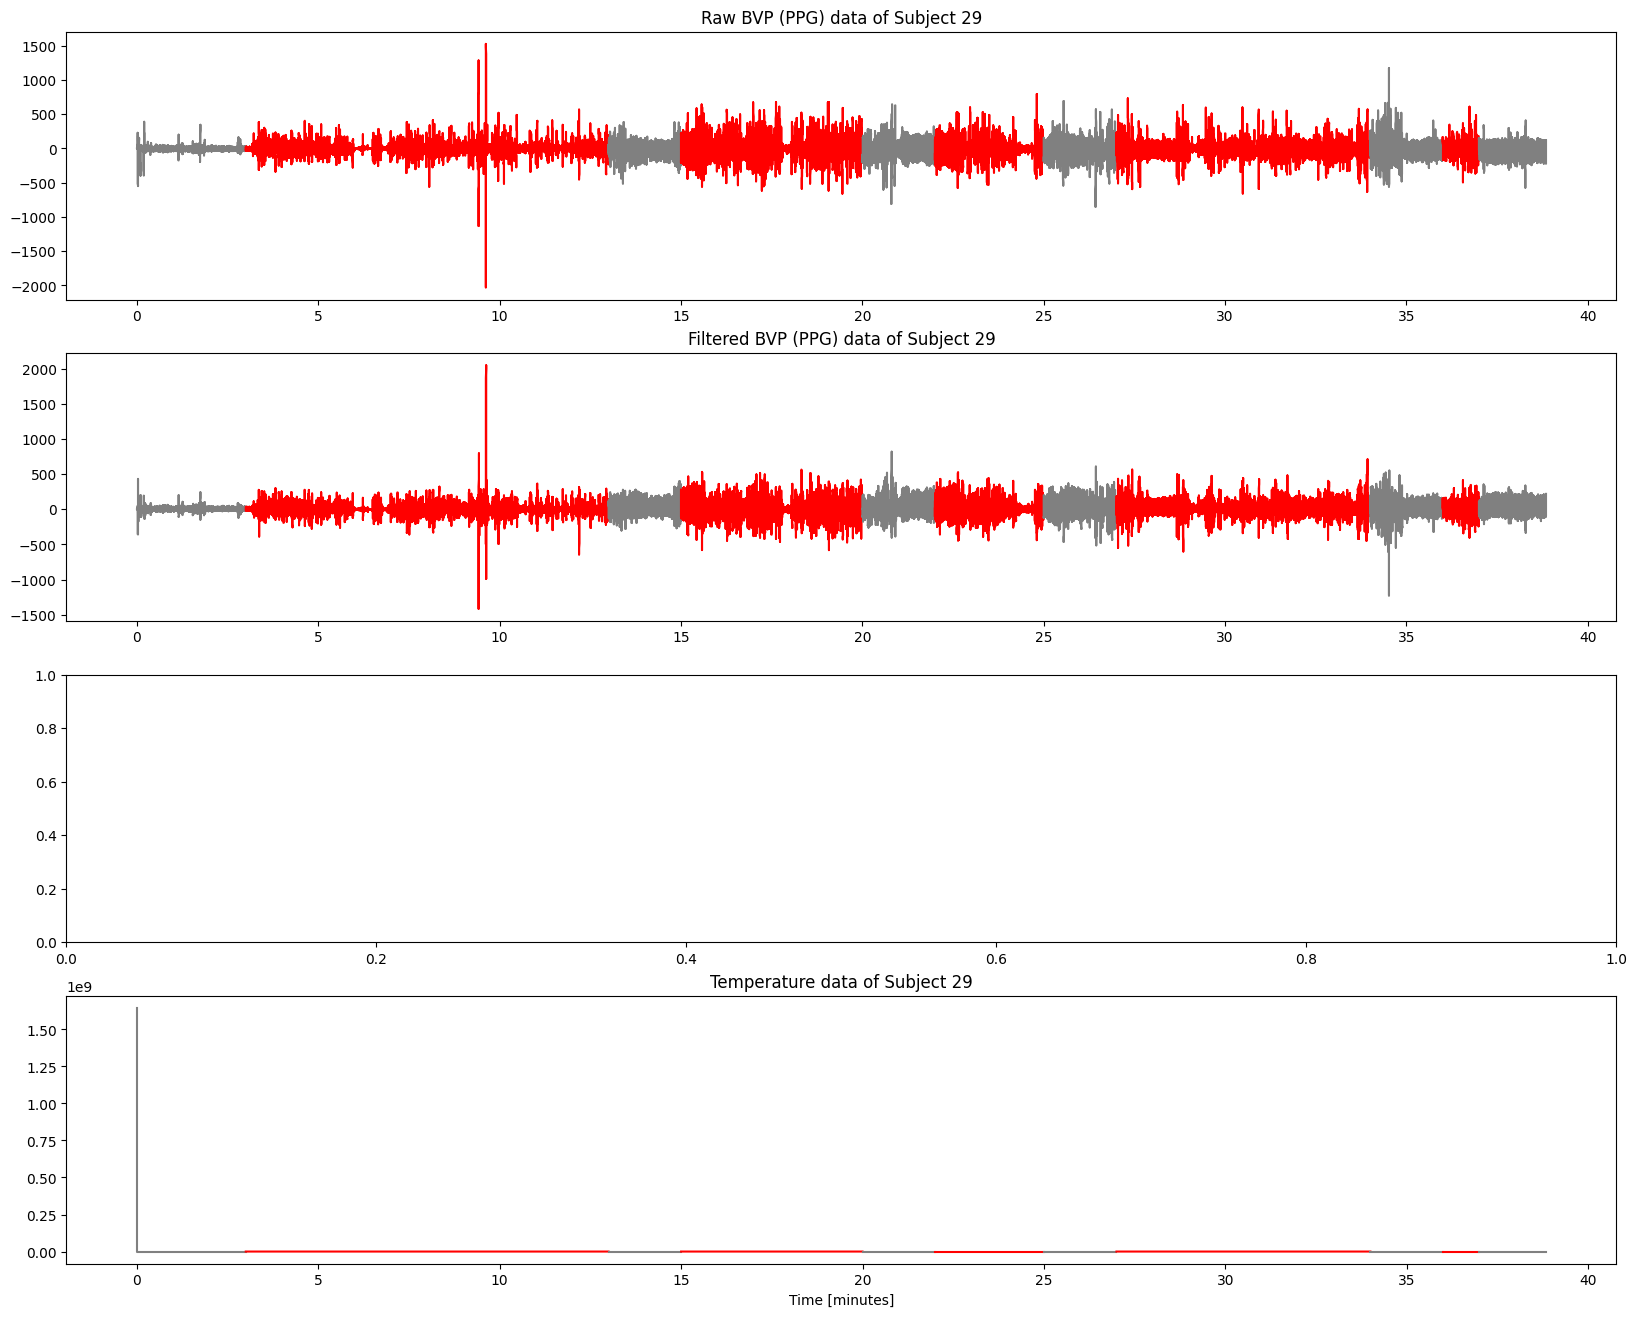

In [ ]:
def calculateColorSegments(dataSize, fs):
    minute = 60*fs
    totalMinutes = round(dataSize/fs/60)

    return [
        (0, minute*3),
        (minute*3, minute*13),
        (minute*13, minute*15),
        (minute*15, minute*20),
        (minute*20, minute*22),
        (minute*22, minute*25),
        (minute*25, minute*27),
        (minute*27, (totalMinutes-5)*minute),
        ((totalMinutes-5)*minute,(totalMinutes-3)*minute),
        ((totalMinutes-3)*minute, (totalMinutes-2)*minute),
        ((totalMinutes-2)*minute, totalMinutes*minute)
    ]

import matplotlib.pyplot as plt

for no, item in enumerate(data):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(20,16))
    colors = ["grey", "red", "grey", "red", "grey", "red", "grey", "red", "grey", "red", "grey"]

    ax1.set_title("Raw BVP (PPG) data of Subject {}".format(no + 1))
    x = [round(i/64/60, 2) for i in range(len(item["bvp"]["raw"]))]
    segments = calculateColorSegments(len(item["bvp"]["raw"]), 64)

    for i, (start, end) in enumerate(segments):
        ax1.plot(x[start:end], item["bvp"]["raw"][start:end], color=colors[i])

    ax2.set_title("Filtered BVP (PPG) data of Subject {}".format(no + 1))
    x = [round(i/64/60, 2) for i in range(len(item["bvp"]["filtered"]))]
    segments = calculateColorSegments(len(item["bvp"]["filtered"]), 64)

    for i, (start, end) in enumerate(segments):
        ax2.plot(x[start:end], item["bvp"]["filtered"][start:end], color=colors[i])

    # ax3.set_title("Raw EDA data of Subject {}".format(no + 1))
    # x = [round(i/4/60, 2) for i in range(len(item["eda"]["raw"]))]
    # segments = calculateColorSegments(len(item["eda"]["raw"]), 4)

    # for i, (start, end) in enumerate(segments):
    #     ax3.plot(x[start:end], item["eda"]["raw"][start:end], color=colors[i])

    ax4.set_title("Temperature data of Subject {}".format(no + 1))
    x = [round(i/4/60, 2) for i in range(len(item["temp"]["raw"]))]
    segments = calculateColorSegments(len(item["temp"]["raw"]), 4)

    for i, (start, end) in enumerate(segments):
        ax4.plot(x[start:end], item["temp"]["raw"][start:end], color=colors[i])

    ax4.set_xlabel('Time [minutes]')

    plt.show()

## Visualisation of 2 min segment ##

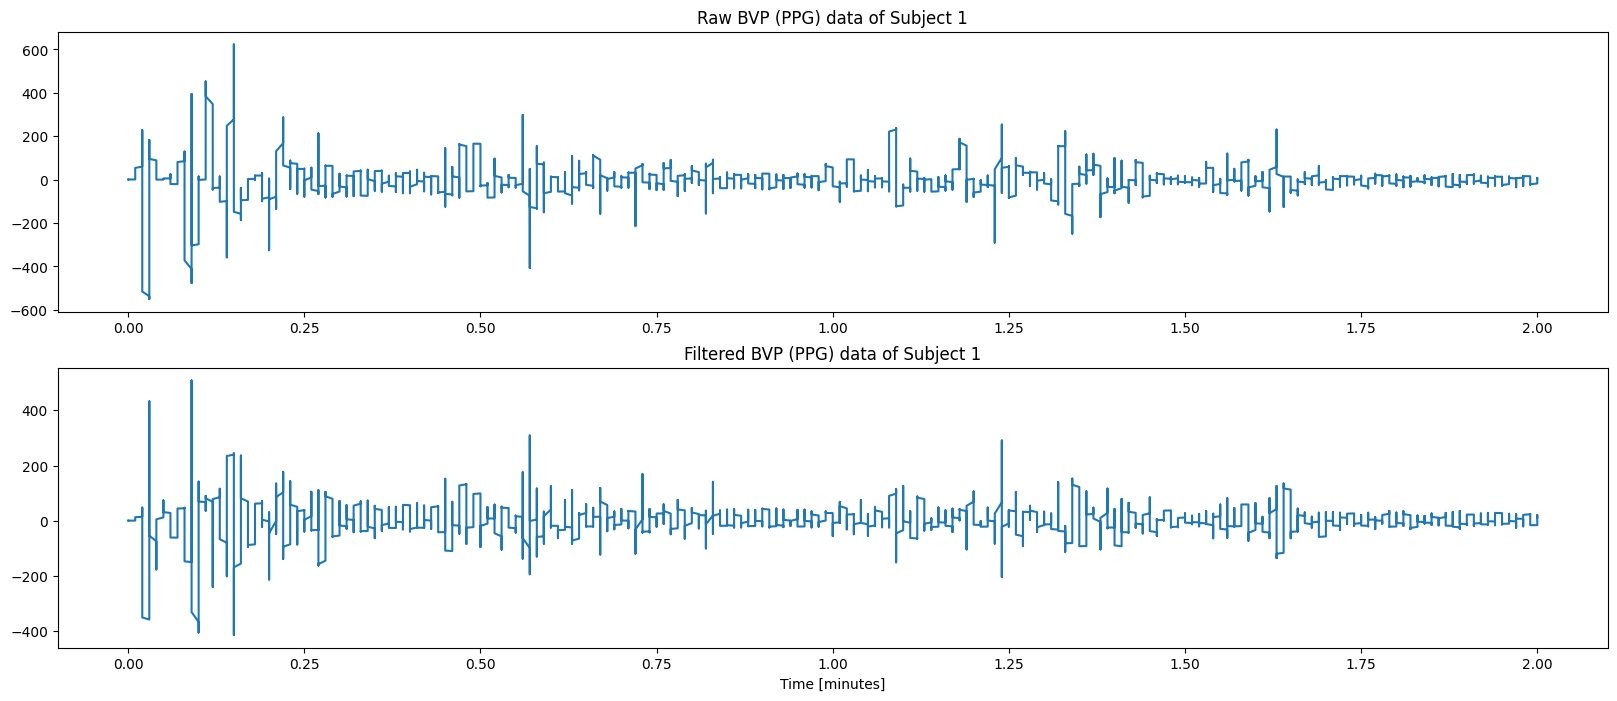

In [ ]:
fig, (ax1, ax2,) = plt.subplots(2,1,figsize=(20,8))
minute = 64*60

ax1.set_title("Raw BVP (PPG) data of Subject 1")
x = [round(i/64/60, 2) for i in range(len(data[0]["bvp"]["raw"][:minute*2]))]
ax1.plot(x, data[0]["bvp"]["raw"][:minute*2])

ax2.set_title("Filtered BVP (PPG) data of Subject 1")
ax2.plot(x, data[0]["bvp"]["filtered"][:minute*2])
ax2.set_xlabel('Time [minutes]')

plt.show()